In [2]:
# Jannik's models are not SAE Lens, so use Baukit
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
# tiny model is in a different direction, add current one to path
import sys
from pathlib import Path
# Get the parent directory of current_dir
parent_dir = str(Path("/root/GroupedSAEs/notebooks/tiny_circuits.ipynb").parent.parent)
sys.path.append(parent_dir)
# from tiny_model.tiny_model import TinyModel, tokenizer
# from nnsight import NNsight
from tiny_model import TinyModel, tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyModel().to(device)

model.to(torch.bfloat16)
# nn_model = NNsight(model)
# model.nnsight_proxy = nn_model

/root/sae-circuits/circuits2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/tokenization/tokenization.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.ser

TinyModel(
  (embed): Embedding(10000, 768)
  (torso): Sequential(
    (0): TransformerBlock(
      (attn): Attention(
        (Q): Linear(in_features=768, out_features=768, bias=False)
        (K): Linear(in_features=768, out_features=768, bias=False)
        (V): Linear(in_features=768, out_features=768, bias=False)
        (O): Linear(in_features=768, out_features=768, bias=True)
        (attn_inp): HookPoint()
        (qs): HookPoint()
        (ks): HookPoint()
        (vs): HookPoint()
        (head_writeouts): HookPoint()
        (catted_head_writeouts): HookPoint()
        (attn_out): HookPoint()
      )
      (mlp): MLP(
        (read_in): Linear(in_features=768, out_features=3072, bias=True)
        (act): ReLU()
        (write_out): Linear(in_features=3072, out_features=768, bias=True)
        (mlp_inp): HookPoint()
        (mlp_out): HookPoint()
      )
      (res_attn): HookPoint()
      (res_mlp): HookPoint()
      (res_final): HookPoint()
    )
    (1): TransformerBlock(


In [145]:
from datasets import load_dataset, Dataset
from tqdm import tqdm
def download_dataset(dataset_name, tokenizer, max_length=256, num_datapoints=None):
    if(num_datapoints):
        split_text = f"train[:{num_datapoints}]"
    else:
        split_text = "train"
    dataset = load_dataset(dataset_name, split=split_text)
    print(dataset)
    total_failed_tokens = 0
    all_tokens = []
    for text in tqdm(dataset["text"]):
        try:
            tokens = [9996] + tokenizer.encode(text)[:max_length]
        except:
            total_failed_tokens += 1
            continue
        # only include if it's at least max_length
        if len(tokens) == max_length+1:
            all_tokens.append(tokens)
    print(f"Failed to tokenize {total_failed_tokens} tokens")
    # convert into a dataset class
    return  Dataset.from_dict({"input_ids": all_tokens})


dataset_name = "noanabeshima/TinyStoriesV2"
max_seq_length = 100
num_datapoints = 40000
# max_seq_length = 100
# num_datapoints = 500
print(f"Downloading {dataset_name}")
dataset = download_dataset(dataset_name, tokenizer=tokenizer, max_length=max_seq_length, num_datapoints=num_datapoints)
true_num_datapoints = len(dataset)
# added BOS
max_seq_length +=1
total_tokens = max_seq_length * true_num_datapoints
print(f"Number of datapoints w/ {max_seq_length} tokens: {true_num_datapoints}")
print(f"Total Tokens: {total_tokens / 1e6}M")


Dataset({
    features: ['text'],
    num_rows: 20000
})


100%|██████████| 20000/20000 [00:31<00:00, 645.13it/s]


Failed to tokenize 0 tokens
Number of datapoints w/ 101 tokens: 19929
Total Tokens: 2.012829M


In [4]:
#set torch grad to zero globally
from torch.utils.data import DataLoader
from einops import rearrange
from tqdm import tqdm
from tiny_model import parse_mlp_tag, SparseMLP
N = 1
# activation_names = [f"A{N}", f"T{N}"]
# activation_names = [f"A{N}", f"A{N+1}"]
# activation_names = [f"T{N}", f"T{N+1}"]
activation_names = [f"Rm{N}_S-3_R1_P0", f"T{N}"]
file, _, _, _ = parse_mlp_tag(activation_names[0])
sae_res = SparseMLP.from_pretrained(file).to(device).to(torch.bfloat16)
file, _, _, _ = parse_mlp_tag(activation_names[1])
skip_sae = SparseMLP.from_pretrained(file).to(device).to(torch.bfloat16)

/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


In [5]:
# sae_res_decoder = sae_res.decoder.weight.data
# sae_skip_encoder = skip_sae.encoder.weight.data
# sae_res_decoder = sae_res_decoder / sae_res_decoder.norm(dim=0, keepdim=True)
# sae_skip_encoder = sae_skip_encoder / sae_skip_encoder.norm(dim=1, keepdim=True)
# sae_res_decoder.shape, sae_skip_encoder.shape
# cos_sim = sae_res_decoder.T @ sae_skip_encoder.T
# max_cos_sim = cos_sim.max(dim=-1).values.cpu().numpy()
# from matplotlib import pyplot as plt
# plt.hist(max_cos_sim, bins=100)
# plt.title(f"Cosine Similarity between {activation_names[0]}-Dec and {activation_names[1]}-Enc")
# plt.show()

In [103]:
batch_size = 15
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)

In [7]:
# skip_first_n_pos = 0
# # def get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32):
# num_features, d_model  = sae_res.encoder.weight.data.shape
# datapoints = dataset.num_rows
# dictionary_activations_res = torch.zeros((datapoints*max_seq_length, num_features))
# dictionary_activations_skip = torch.zeros((datapoints*max_seq_length, num_features))
# all_dictionary_activations = [dictionary_activations_res, dictionary_activations_skip]
# token_list = torch.zeros((datapoints*max_seq_length), dtype=torch.int64)


# residual_and_skip_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
# residual_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)
# skip_correlation = torch.zeros((num_features, num_features), dtype=torch.int32)

# feature_mse = torch.zeros(datapoints*max_seq_length)
# feature_var_explained = torch.zeros(datapoints*max_seq_length)

# with torch.no_grad(), dataset.formatted_as("pt"):
#     for batch_ind, batch in enumerate(tqdm(dl)):
#         batch = batch.to(model.device)
#         token_list[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
#         for sae_ind, sae in enumerate([sae_res, skip_sae]):
#             feature_acts = model[activation_names[sae_ind]](batch)
#             feature_acts[:, :skip_first_n_pos] = 0
#             feature_acts = rearrange(feature_acts, "b s n -> (b s) n" )

#             all_dictionary_activations[sae_ind][batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = feature_acts.cpu()
#             if sae_ind==0:
#                 reconstruction_residual = sae.decoder(feature_acts)
#                 first_feature_mask = (feature_acts !=0).float()
#                 residual_correlation += torch.mm(first_feature_mask.T, first_feature_mask).int().cpu()
#             else:
#                 second_feature_mask = (feature_acts !=0).float()
#                 skip_correlation += torch.mm(second_feature_mask.T, second_feature_mask).int().cpu()

#                 # Calculate the correlation between the residual and skip activations
#                 residual_and_skip_correlation += torch.mm(first_feature_mask.T, second_feature_mask).int().cpu()


#                 # Check the MSE between the skip features & skip-features-w/-residual
#                 skip_feature_x_hat = skip_sae.encoder(reconstruction_residual)
#                 skip_feature_mse = torch.mean((skip_feature_x_hat - feature_acts)**2, dim=-1)
#                 feature_act_var = torch.var(feature_acts)
#                 skip_feature_var_explained = 1 - skip_feature_mse / feature_act_var
#                 feature_mse[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_mse.cpu()
#                 feature_var_explained[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = skip_feature_var_explained.cpu()

In [131]:
import torch
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm

def get_nonzero_indices(tensor, threshold=1e-6):
    return (tensor.abs() > threshold).sum(dim=0).nonzero().squeeze()

def compute_efficient_attribution(sae_res, skip_sae, input_nonzero_indices, output_nonzero_indices, nonzero_input):
    nonzero_input = nonzero_input.detach().requires_grad_(True)
    
    masked_decoder_weight = sae_res.decoder.weight[:, input_nonzero_indices].detach()
    masked_decoder_bias = sae_res.decoder.bias.detach()
    masked_encoder_weight = skip_sae.encoder.weight[output_nonzero_indices, :].detach()
    masked_encoder_bias = skip_sae.encoder.bias[output_nonzero_indices].detach()
    
    decoder_output = F.linear(nonzero_input, masked_decoder_weight, masked_decoder_bias)
    encoder_output = F.linear(decoder_output, masked_encoder_weight, masked_encoder_bias)
    encoder_output = F.relu(encoder_output)
    
    all_attribution = []
    for i in range(encoder_output.shape[1]):
        grad = torch.autograd.grad(encoder_output[:, i].sum(), nonzero_input, retain_graph=True)[0]
        # all_attribution (grad * nonzero_input).detach()
        attri = (grad*nonzero_input).detach()
        attri_sum = attri.sum(-1)
        normed_attri = (attri / attri_sum[:, None]).nanmean(dim=0)
        all_attribution.append(normed_attri)
    return torch.stack(all_attribution, dim=1)

# def compute_efficient_jacobian(model, sae_res, skip_sae, dl, activation_names, batch_size, max_seq_length):
device = model.device
attribution_sum = None
sample_count = 0

for batch_ind, batch in enumerate(tqdm(dl)):
    batch = batch.to(device)
    
    with torch.no_grad():
        feature_acts = model[activation_names[0]](batch)
        feature_acts = rearrange(feature_acts, "b s n -> (b s) n")

        # Identify non-zero input elements
        input_nonzero_indices = get_nonzero_indices(feature_acts)

        # Perform a forward pass to identify non-zero output elements
        relu = torch.nn.ReLU()
        initial_output = relu(skip_sae.encoder(sae_res.decoder(feature_acts)) + skip_sae.encoder.bias)
        output_nonzero_indices = get_nonzero_indices(initial_output)

    # print(f"shape of input activations: {feature_acts.shape}")
    # print(f"shape of initial output activations: {initial_output.shape}")
    # print(f"number of nonzero input indices: {input_nonzero_indices.shape}")
    # print(f"number of nonzero output indices: {output_nonzero_indices.shape}")

    # Extract non-zero input values
    nonzero_input = feature_acts[:, input_nonzero_indices]

    # Compute attribution
    # encoder_output, grad, nonzero_input = compute_efficient_attribution(sae_res, skip_sae, input_nonzero_indices, 
    # output_nonzero_indices, nonzero_input)
    batch_attribution = compute_efficient_attribution(sae_res, skip_sae, input_nonzero_indices, 
    output_nonzero_indices, nonzero_input)

    # Assertions for shape verification
    # assert batch_attribution.shape == input_nonzero_indices.shape, f"batch_attribution shape {batch_attribution.shape} doesn't match input_nonzero_indices shape {input_nonzero_indices.shape}"

    # Update attribution sum
    if attribution_sum is None:
        attribution_sum = torch.zeros(sae_res.decoder.weight.shape[1], skip_sae.encoder.weight.shape[0], device="cpu")
        attribution_count = torch.zeros(sae_res.decoder.weight.shape[1], skip_sae.encoder.weight.shape[0], device="cpu")
    
    # Vectorized approach to add batch_attribution to the correct positions
    # output_indices = output_nonzero_indices.cpu().unsqueeze(1).expand(-1, len(input_nonzero_indices))
    # input_indices = input_nonzero_indices.cpu().unsqueeze(0).expand(len(output_nonzero_indices), -1)
    # attribution_sum[input_nonzero_indices[:, None].cpu(), output_nonzero_indices.cpu()] += batch_attribution.cpu()
    # attribution_count[input_nonzero_indices[:, None].cpu(), output_nonzero_indices.cpu()] += 1
    # Create a mask for non-zero entries in batch_attribution
    non_zero_mask = batch_attribution != 0

    # Use this mask to update attribution_sum and attribution_count
    attribution_sum[input_nonzero_indices[:, None].cpu(), output_nonzero_indices.cpu()] += batch_attribution.cpu() * non_zero_mask.cpu()
    attribution_count[input_nonzero_indices[:, None].cpu(), output_nonzero_indices.cpu()] += non_zero_mask.cpu().to(torch.int)

    # sample_count += nonzero_input.shape[0]

    # Print out memory usage
    # print(f" Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    torch.cuda.empty_cache()

# Normalize the attribution sum by the total number of samples
# average_attribution = attribution_sum / sample_count
# average_attribution = attribution_sum / attribution_count
average_attribution = torch.nan_to_num(attribution_sum / attribution_count, nan=0.0)
#TODO: Only divide by nonzero elements.


# Usage
# average_attribution = compute_efficient_jacobian(model, sae_res, skip_sae, dl, activation_names, batch_size, max_seq_length)

# print("Average Attribution shape:", average_attribution.shape)
# print("Average Attribution (first few elements):\n", average_attribution[:5, :5])

  0%|          | 0/50 [00:00<?, ?it/s]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st

In [ ]:
# save attribution
torch.save(average_attribution, f"{activation_names[0]}_{activation_names[1]}_average_attribution.pt")

In [135]:
average_attribution = torch.nan_to_num(attribution_sum / attribution_count, nan=0.0)


In [144]:
average_attribution[:, 0].topk(10)

torch.return_types.topk(
values=tensor([0.8145, 0.1130, 0.0169, 0.0161, 0.0139, 0.0074, 0.0058, 0.0057, 0.0041,
        0.0038]),
indices=tensor([   12,   120,   418,   324,  1506,  1237, 12037,    46,  2945,   113]))

In [134]:
average_attribution.isnan().sum() / average_attribution.numel()

tensor(0.9971)

In [132]:
batch_attribution, average_attribution

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-1.8463e-03,  0.0000e+00,  4.7913e-03,  ...,  2.1606e-02,
          -3.7670e-05,  1.9165e-02],
         [-3.0518e-02,  0.0000e+00,  1.3672e-02,  ..., -3.0151e-02,
          -9.4604e-04,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00, -1.6168e-06,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]], device='cuda:0', dtype=torch.bfloat16),
 tensor([[        nan,         nan, -2.0041e-07,  ...,         nan,
                  nan,         nan],
         [-1.7041e-03,         nan,  4.2609e-03,  ...,         nan,
                  nan,         nan],
         [-1.7772e-02,         nan,  4.0830e-03,  ...,         nan,
                  nan,         nan],


In [113]:
attribution_sum, attribution_count

(tensor([[ 0.0000e+00,  0.0000e+00, -8.0164e-07,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-8.5205e-02,  0.0000e+00,  2.1304e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-8.8860e-01,  0.0000e+00,  2.0415e-01,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]]),
 tensor([[43., 43., 43.,  ...,  0.,  0.,  0.],
         [50., 50., 50.,  ...,  0.,  0.,  0.],
         [50., 50., 50.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]))

In [106]:
import torch

# Setup
full_matrix = torch.zeros(3, 5)
output_nonzero_indices = torch.tensor([0, 2])
input_nonzero_indices = torch.tensor([1, 3])
batch_attribution = torch.tensor([[1.0, 2.0],
                                  [3.0, 4.0]])

# Vectorized assignment
full_matrix[output_nonzero_indices[:, None], input_nonzero_indices] = batch_attribution

print("Matrix after vectorized assignment:")
print(full_matrix)

Matrix after vectorized assignment:
tensor([[0., 1., 0., 2., 0.],
        [0., 0., 0., 0., 0.],
        [0., 3., 0., 4., 0.]])


In [105]:
output_indices, input_indices

(tensor([[    0,     0,     0,  ...,     0,     0,     0],
         [    1,     1,     1,  ...,     1,     1,     1],
         [    2,     2,     2,  ...,     2,     2,     2],
         ...,
         [15401, 15401, 15401,  ..., 15401, 15401, 15401],
         [16814, 16814, 16814,  ..., 16814, 16814, 16814],
         [18383, 18383, 18383,  ..., 18383, 18383, 18383]]),
 tensor([[    0,     1,     2,  ..., 21295, 21299, 21313],
         [    0,     1,     2,  ..., 21295, 21299, 21313],
         [    0,     1,     2,  ..., 21295, 21299, 21313],
         ...,
         [    0,     1,     2,  ..., 21295, 21299, 21313],
         [    0,     1,     2,  ..., 21295, 21299, 21313],
         [    0,     1,     2,  ..., 21295, 21299, 21313]]))

In [96]:
attribution_sum, attribution_count

(tensor([[ -1.0326,   0.0000,  -0.0539,  ...,   0.0000,   0.0000,   0.0000],
         [ -0.5197,   0.0000,   1.2892,  ...,   0.0000,   0.0000,   0.0000],
         [-11.3419,   0.0000,   2.8043,  ...,   0.0000,   0.0000,   0.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
         [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]),
 tensor([[665., 665., 665.,  ...,   0.,   0.,   0.],
         [665., 665., 665.,  ...,   0.,   0.,   0.],
         [665., 665., 665.,  ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]]))

In [73]:
max_vals = average_attribution.max(-1).values
max_vals

tensor([nan, nan, nan,  ..., nan, nan, nan])

In [79]:
average_attribution.count_nonzero() / average_attribution.numel()

tensor(0.0134)

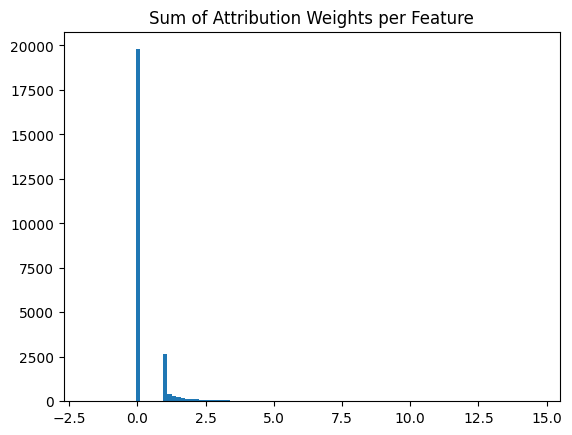

In [92]:
summed = average_attribution.sum(dim=0).numpy()
from matplotlib import pyplot as plt
plt.hist(summed, bins=100)
plt.title("Sum of Attribution Weights per Feature")

plt.show()

In [77]:
average_attribution[average_attribution.isnan()] = 0

In [13]:
encoder_output.shape, grad.shape, nonzero_input.shape
attri = (grad*nonzero_input).detach()
attri_sum = attri.sum(-1)
normed_attri = attri / attri_sum[:, None]
normed_attri[74].sum(), normed_attri[74].max(), normed_attri[74].min()

(tensor(0.9961, device='cuda:0', dtype=torch.bfloat16),
 tensor(1.0859, device='cuda:0', dtype=torch.bfloat16),
 tensor(-0.0320, device='cuda:0', dtype=torch.bfloat16))

In [35]:
feature_acts.shape

torch.Size([1515, 25000])

In [17]:
nonzero_input

tensor([[0.0000, 0.3555, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [8.3750, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [9.6250, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [45]:
all_attribution = []
for i in range(encoder_output.shape[1]):
    grad = torch.autograd.grad(encoder_output[:, i].sum(), nonzero_input, retain_graph=True)[0]
    # all_attribution (grad * nonzero_input).detach()
    attri = (grad*nonzero_input).detach()
    attri_sum = attri.sum(-1)
    normed_attri = (attri / attri_sum[:, None]).nanmean(dim=0)
    all_attribution.append(normed_attri)
stacked_attr = torch.stack(all_attribution, dim=1)

In [38]:
nonzero_input.shape, encoder_output.shape[1], normed_attri.nanmean(0)

(torch.Size([1515, 7588]),
 895,
 tensor([0.0000, 0.0074, 0.0000,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0',
        dtype=torch.bfloat16))

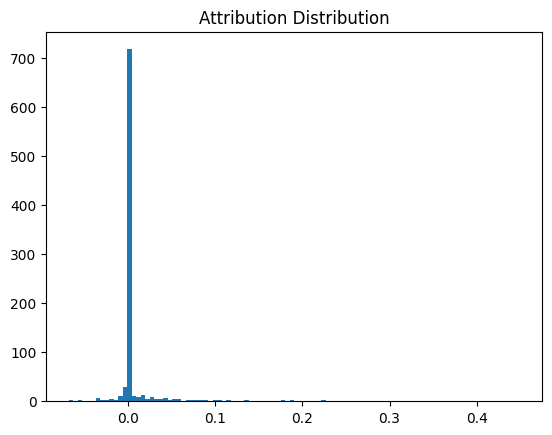

In [63]:
stacked_attr[1].sum()
v = stacked_attr[7]
# plot as hist
import numpy as np
import matplotlib.pyplot as plt
plt.hist(v.cpu().float().numpy(), bins=100)
plt.title(f"Attribution Distribution")
plt.show()

In [29]:
del grad, attri, attri_sum
torch.cuda.empty_cache()

In [31]:
stacked_attr.shape

torch.Size([1515, 895, 7588])

In [7]:
import torch
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm

def get_nonzero_indices(tensor, threshold=1e-6):
    return (tensor.abs() > threshold).sum(dim=0).nonzero().squeeze()

def compute_efficient_attribution(sae_res, skip_sae, input_nonzero_indices, output_nonzero_indices, nonzero_input):
    nonzero_input = nonzero_input.detach().requires_grad_(True)
    
    masked_decoder_weight = sae_res.decoder.weight[:, input_nonzero_indices].detach()
    masked_decoder_bias = sae_res.decoder.bias.detach()
    masked_encoder_weight = skip_sae.encoder.weight[output_nonzero_indices, :].detach()
    masked_encoder_bias = skip_sae.encoder.bias[output_nonzero_indices].detach()
    
    decoder_output = F.linear(nonzero_input, masked_decoder_weight, masked_decoder_bias)
    encoder_output = F.linear(decoder_output, masked_encoder_weight, masked_encoder_bias)
    encoder_output = F.relu(encoder_output)
    
    attribution_sum = torch.zeros_like(nonzero_input)
    
    for i in range(encoder_output.shape[1]):
        grad = torch.autograd.grad(encoder_output[:, i].sum(), nonzero_input, retain_graph=True)[0]
        attribution_sum += (grad * nonzero_input).detach()
    
    return attribution_sum.sum(dim=0)  # Sum over batch dimension

def compute_efficient_jacobian(model, sae_res, skip_sae, dl, activation_names, batch_size, max_seq_length):
    device = model.device
    attribution_sum = None
    sample_count = 0

    for batch_ind, batch in enumerate(tqdm(dl)):
        batch = batch.to(device)
        
        with torch.no_grad():
            feature_acts = model[activation_names[0]](batch)
            feature_acts = rearrange(feature_acts, "b s n -> (b s) n")

            # Identify non-zero input elements
            input_nonzero_indices = get_nonzero_indices(feature_acts)

            # Perform a forward pass to identify non-zero output elements
            relu = torch.nn.ReLU()
            initial_output = relu(skip_sae.encoder(sae_res.decoder(feature_acts)) + skip_sae.encoder.bias)
            output_nonzero_indices = get_nonzero_indices(initial_output)

        # print(f"shape of input activations: {feature_acts.shape}")
        # print(f"shape of initial output activations: {initial_output.shape}")
        # print(f"number of nonzero input indices: {input_nonzero_indices.shape}")
        # print(f"number of nonzero output indices: {output_nonzero_indices.shape}")

        # Extract non-zero input values
        nonzero_input = feature_acts[:, input_nonzero_indices]

        # Compute attribution
        batch_attribution = compute_efficient_attribution(sae_res, skip_sae, input_nonzero_indices, output_nonzero_indices, nonzero_input)

        # Assertions for shape verification
        assert batch_attribution.shape == input_nonzero_indices.shape, f"batch_attribution shape {batch_attribution.shape} doesn't match input_nonzero_indices shape {input_nonzero_indices.shape}"

        # Update attribution sum
        if attribution_sum is None:
            attribution_sum = torch.zeros(skip_sae.encoder.weight.shape[0], sae_res.decoder.weight.shape[1], device="cpu")
            attribution_count = torch.zeros(skip_sae.encoder.weight.shape[0], sae_res.decoder.weight.shape[1], device="cpu")
        
        # Vectorized approach to add batch_attribution to the correct positions
        output_indices = output_nonzero_indices.cpu().unsqueeze(1).expand(-1, len(input_nonzero_indices))
        input_indices = input_nonzero_indices.cpu().unsqueeze(0).expand(len(output_nonzero_indices), -1)
        attribution_sum[output_indices, input_indices] += batch_attribution.cpu()
        attribution_count[output_indices, input_indices] += 1

        # sample_count += nonzero_input.shape[0]

        # Print out memory usage
        # print(f" Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        torch.cuda.empty_cache()

    # Normalize the attribution sum by the total number of samples
    # average_attribution = attribution_sum / sample_count
    average_attribution = attribution_sum / attribution_count
    #TODO: Only divide by nonzero elements.

    return average_attribution

# Usage
average_attribution = compute_efficient_jacobian(model, sae_res, skip_sae, dl, activation_names, batch_size, max_seq_length)

print("Average Attribution shape:", average_attribution.shape)
print("Average Attribution (first few elements):\n", average_attribution[:5, :5])

  0%|          | 0/665 [00:00<?, ?it/s]

/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
  0%|          | 1/665 [00:02<26:57,  2.44s/it]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

Average Attribution shape: torch.Size([25000, 25000])
Average Attribution (first few elements):
 tensor([[-0.0288,  0.0914,  0.2016,  0.0237,  0.0517],
        [-0.0288,  0.0914,  0.2016,  0.0237,  0.0517],
        [-0.0288,  0.0914,  0.2016,  0.0237,  0.0517],
        [-0.0280,  0.0892,  0.2017,  0.0228,  0.0499],
        [-0.0288,  0.0914,  0.2016,  0.0237,  0.0517]])


In [8]:
# Save results
torch.save(average_attribution, f"{activation_names[0]}_{activation_names[1]}_average_attribution.pt")

In [15]:
ind = average_attribution[0].abs().topk(10).indices
average_attribution[0, ind]

tensor([0.5049, 0.4469, 0.4379, 0.3791, 0.3745, 0.3062, 0.2586, 0.2399, 0.2297,
        0.2177])

In [45]:
import torch
import torch.nn.functional as F

# Define our simple linear transformation (without transpose)
weight = torch.tensor([[1.0, 2.0, 0.0],
                       [0.0, 0.0, 3.0]])
# bias = torch.tensor([0.5, 1.0])

# Input as a batch
x = torch.tensor([[2.0, 3.0, 1.0],
                  [3.0, 2.0, 0.0],
                  [0.0, 0.0, 1.0],
                  [0.0, 0.0, 0.0], 
                  [0.0, 0.0, 0.0]], requires_grad=True)

# Forward pass
y = F.linear(x, weight)
print("Output y:")
print(y)

# Calculate attribution
attribution_list = []
for i in range(y.shape[1]):  # Iterate over output dimensions
    grad = torch.autograd.grad(y[:, i].sum(), x, retain_graph=True)[0]
    attr = grad * x
    attribution_list.append(attr)

attribution = torch.stack(attribution_list, dim=1)
print("\nRaw attribution:")
print(attribution)

# Normalize attribution
# Add a small epsilon to avoid division by zero
epsilon = 1e-10
normalized_attribution = attribution / (y.unsqueeze(-1) + epsilon)
print("\nNormalized attribution:")
print(normalized_attribution)

# Sum normalized attribution across output dimensions
summed_normalized_attribution = normalized_attribution.sum(dim=0)/2
print("\nSummed normalized attribution:")
print(summed_normalized_attribution)

# Calculate mean of non-zero outputs
non_zero_mask = (y.abs().sum(dim=1) > epsilon)
mean_non_zero_attribution = summed_normalized_attribution[non_zero_mask].mean(dim=0)
print("\nMean of non-zero summed normalized attribution:")
print(mean_non_zero_attribution)

Output y:
tensor([[8., 3.],
        [7., 0.],
        [0., 3.],
        [0., 0.],
        [0., 0.]], grad_fn=<MmBackward0>)

Raw attribution:
tensor([[[2., 6., 0.],
         [0., 0., 3.]],

        [[3., 4., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 3.]],

        [[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<StackBackward0>)

Normalized attribution:
tensor([[[0.2500, 0.7500, 0.0000],
         [0.0000, 0.0000, 1.0000]],

        [[0.4286, 0.5714, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]]], grad_fn=<DivBackward0>)

Summed normalized attribution:
tensor([[0.3393, 0.6607, 0.0000],
        [0.0000, 0.0000, 1.0000]], grad_fn=<DivBackward0>)


IndexError: The shape of the mask [5] at index 0 does not match the shape of the indexed tensor [2, 3] at index 0

In [54]:
(torch.stack(attribution_list, dim=1)[:3]/ y[:3].unsqueeze(-1)).nanmean(dim=0)

tensor([[0.3393, 0.6607, 0.0000],
        [0.0000, 0.0000, 1.0000]], grad_fn=<DivBackward0>)

In [11]:
# average_attribution
for i in range(0,10):
    threshold = 0.1**i
    print(threshold, "| ", (average_attribution.abs() > threshold).sum())

1.0 |  tensor(0)
0.1 |  tensor(14683)
0.010000000000000002 |  tensor(300834)
0.0010000000000000002 |  tensor(2131137)
0.00010000000000000002 |  tensor(11495318)
1.0000000000000003e-05 |  tensor(39015914)
1.0000000000000004e-06 |  tensor(67084179)
1.0000000000000004e-07 |  tensor(81507033)
1.0000000000000005e-08 |  tensor(87559738)
1.0000000000000005e-09 |  tensor(89375789)


In [7]:
# Attribution patching w/ zero ablation

import torch
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm
import numpy as np

def get_nonzero_indices(tensor, threshold=1e-6):
    return (tensor.abs() > threshold).sum(dim=0).nonzero().squeeze()


def compute_efficient_attribution(sae_res, skip_sae, input_nonzero_indices, output_nonzero_indices, interpolated_input, original_input, original_output):
    interpolated_input.requires_grad_(True)
    
    masked_decoder_weight = sae_res.decoder.weight[:, input_nonzero_indices]
    masked_decoder_bias = sae_res.decoder.bias
    masked_encoder_weight = skip_sae.encoder.weight[output_nonzero_indices, :]
    masked_encoder_bias = skip_sae.encoder.bias[output_nonzero_indices]
    
    decoder_output = F.linear(interpolated_input, masked_decoder_weight, masked_decoder_bias)
    encoder_output = F.linear(decoder_output, masked_encoder_weight, masked_encoder_bias)
    encoder_output = F.relu(encoder_output)

    output_difference = encoder_output - original_output
    input_difference = -1*original_input
    
    attribution = torch.zeros(len(output_nonzero_indices), len(input_nonzero_indices), device=interpolated_input.device)
    for i in range(len(output_nonzero_indices)):
        grad = torch.autograd.grad(output_difference[:, i].sum(), interpolated_input, retain_graph=True)[0]
        attribution[i] = (grad * input_difference).sum(dim=0).detach()

    return attribution

def compute_efficient_jacobian(model, sae_res, skip_sae, dl, activation_names, batch_size, max_seq_length):
    device = model.device
    attribution_sum = None
    sample_count = 0

    for batch_ind, batch in enumerate(tqdm(dl)):
        batch = batch.to(device)
        
        feature_acts = model[activation_names[0]](batch)
        feature_acts = rearrange(feature_acts, "b s n -> (b s) n")

        # Identify non-zero input elements
        input_nonzero_indices = get_nonzero_indices(feature_acts)

        # Perform a forward pass to identify non-zero output elements
        with torch.no_grad():
            relu = torch.nn.ReLU()
            initial_output = relu(skip_sae.encoder(sae_res.decoder(feature_acts)) + skip_sae.encoder.bias)
        output_nonzero_indices = get_nonzero_indices(initial_output)

        # print(f"shape of input activations: {feature_acts.shape}")
        # print(f"shape of initial output activations: {initial_output.shape}")
        # print(f"number of nonzero input indices: {input_nonzero_indices.shape}")
        # print(f"number of nonzero output indices: {output_nonzero_indices.shape}")
        # print("input-output shape: ", input_nonzero_indices.shape, output_nonzero_indices.shape)

        # Extract non-zero input values
        nonzero_input = feature_acts[:, input_nonzero_indices]
        nonzero_output = initial_output[:, output_nonzero_indices]
        
        # Integrated Gradients with Zero Ablation
        batch_attribution = torch.zeros(len(output_nonzero_indices), len(input_nonzero_indices), device=device)
        
        for alpha in np.linspace(0, 1, 7):
            interpolated_input = alpha * nonzero_input
            
            # Compute attribution for interpolated input
            interp_attribution = compute_efficient_attribution(sae_res, skip_sae, input_nonzero_indices, output_nonzero_indices, interpolated_input, nonzero_input, nonzero_output)
            
            batch_attribution += interp_attribution
        
        # Average the attribution
        batch_attribution /= 7

        # Assertions for shape verification
        assert batch_attribution.shape == (len(output_nonzero_indices), len(input_nonzero_indices)), f"batch_attribution shape {batch_attribution.shape} doesn't match expected shape {(len(output_nonzero_indices), len(input_nonzero_indices))}"

        # Update attribution sum
        if attribution_sum is None:
            attribution_sum = torch.zeros(skip_sae.encoder.weight.shape[0], sae_res.decoder.weight.shape[1], device="cpu")
        
        output_indices = output_nonzero_indices.cpu().unsqueeze(1).expand(-1, len(input_nonzero_indices))
        input_indices = input_nonzero_indices.cpu().unsqueeze(0).expand(len(output_nonzero_indices), -1)
        attribution_sum[output_indices, input_indices] += batch_attribution.detach().cpu()

        sample_count += nonzero_input.shape[0]

        # Print out memory usage
        # print(f" Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        torch.cuda.empty_cache()

    # Normalize the attribution sum by the total number of samples
    average_attribution = attribution_sum / sample_count

    return average_attribution

# Usage
average_attribution = compute_efficient_jacobian(model, sae_res, skip_sae, dl, activation_names, batch_size, max_seq_length)

print("Average Attribution shape:", average_attribution.shape)
print("Average Attribution (first few elements):\n", average_attribution[:5, :5])

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
  2%|▏         | 1/50 [00:03<02:45,  3.37s/it]/root/sae-circuits/circuits2/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless t

Average Attribution shape: torch.Size([25000, 25000])
Average Attribution (first few elements):
 tensor([[ 0.0000e+00, -7.8852e-04,  0.0000e+00,  0.0000e+00, -8.0679e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.1500e-06, -3.6827e-01,  2.7705e-02,  1.1033e-02, -4.3740e-03],
        [ 0.0000e+00, -3.0780e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00]])


In [ ]:
# Save the attribution
torch.save(average_attribution, "average_attribution.pt")

In [ ]:
average_attribution

In [11]:
top_ind = average_attribution[4:].max(dim=0).values.topk(20).indices
for t_i in top_ind:
    print("Trans(output): ", t_i)
    print(average_attribution[:, t_i].topk(10))

Trans(output):  tensor(931)
torch.return_types.topk(
values=tensor([9.8407e-04, 9.6671e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
indices=tensor([8, 3, 7, 4, 9, 5, 1, 0, 2, 6]))
Trans(output):  tensor(351)
torch.return_types.topk(
values=tensor([8.4457e-04, 2.2192e-04, 1.0401e-04, 5.4360e-05, 4.9184e-05, 4.4101e-05,
        4.0298e-05, 3.7457e-05, 3.5323e-05, 3.4636e-05]),
indices=tensor([ 129,  128,   25, 1246,  205,  169,  362, 1319, 2630,  323]))
Trans(output):  tensor(2405)
torch.return_types.topk(
values=tensor([8.1942e-04, 1.9559e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
indices=tensor([ 8, 54,  7,  4,  9,  1,  0,  5, 10,  2]))
Trans(output):  tensor(435)
torch.return_types.topk(
values=tensor([7.6914e-04, 3.1301e-04, 1.4089e-04, 9.4971e-05, 7.5060e-05, 6.2596e-05,
        6.1760e-05, 5.8894e-05, 5.7006e-05, 4.8569e-05]),
indices=tensor([   8,  

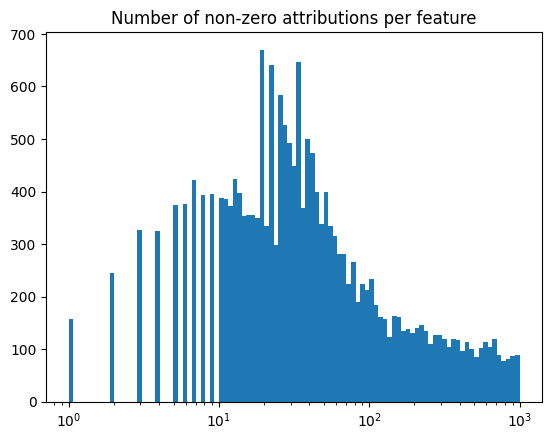

In [11]:
# plot as hist
import matplotlib.pyplot as plt
nz_att = (average_attribution.abs() > 0).sum(dim=0).cpu().numpy()
plt.hist(nz_att, bins=np.logspace(0, 3, 100))
plt.title("Number of non-zero attributions per feature")
# x on log scale
plt.xscale("log")
plt.show()

In [32]:
# save average_attribution
torch.save(average_attribution, "average_attribution.pt")

In [19]:
average_attribution[:, 38].topk(10), average_attribution[6].topk(10)

(torch.return_types.topk(
 values=tensor([2.2425e-01, 2.1201e-04, 1.1401e-05, 5.1755e-06, 1.8601e-06, 1.0901e-06,
         7.3858e-07, 4.8418e-07, 4.7597e-07, 1.8464e-07]),
 indices=tensor([    6,     1,     4, 12227,  3353,     8, 11682,  6176, 17684,  1607])),
 torch.return_types.topk(
 values=tensor([0.2242, 0.0011, 0.0007, 0.0007, 0.0006, 0.0006, 0.0005, 0.0004, 0.0004,
         0.0004]),
 indices=tensor([  38, 1392, 1246,  768,  661,   34, 1180,  490, 1350,  854])))

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Toy model
class ToyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Linear(3, 4)
        self.encoder = nn.Linear(4, 2)
        
        # Set known weights for predictability
        self.decoder.weight.data = torch.tensor([[1., 2., 3.],
                                                 [4., 5., 6.],
                                                 [7., 8., 9.],
                                                 [10., 11., 12.]])
        self.decoder.bias.data = torch.tensor([0.1, 0.2, 0.3, 0.4])
        
        self.encoder.weight.data = torch.tensor([[1., 2., 3., 4.],
                                                 [5., 6., 7., 8.]])
        self.encoder.bias.data = torch.tensor([0.5, 0.6])

    def forward(self, x):
        x = self.decoder(x)
        x = F.relu(x)
        x = self.encoder(x)
        return x

# Toy dataset
toy_data = torch.tensor([[1., 0., 1.],
                         [0., 1., 1.],
                         [1., 1., 0.]])

# Simplified version of our functions
def get_nonzero_indices(tensor, threshold=1e-6):
    return (tensor.abs() > threshold).nonzero().squeeze(1)

def compute_efficient_attribution(model, input_nonzero_indices, output_nonzero_indices, interpolated_input):
    interpolated_input.requires_grad_(True)
    
    decoder_output = model.decoder(interpolated_input)
    encoder_output = model.encoder(F.relu(decoder_output))
    
    attribution = torch.zeros(len(output_nonzero_indices), len(input_nonzero_indices), device=interpolated_input.device)
    for i in range(len(output_nonzero_indices)):
        grad = torch.autograd.grad(encoder_output[:, i].sum(), interpolated_input, retain_graph=True)[0]
        attribution[i] = (grad * interpolated_input).sum(dim=0)[input_nonzero_indices]
    
    return attribution
def compute_toy_jacobian(model, data):
    device = next(model.parameters()).device
    attribution_sum = None
    sample_count = 0

    batch = data.to(device)  # Process all data at once
    
    # Identify non-zero input elements
    input_nonzero_indices = get_nonzero_indices(batch)

    # Perform a forward pass to identify non-zero output elements
    with torch.no_grad():
        initial_output = model(batch)
    output_nonzero_indices = get_nonzero_indices(initial_output)

    # Integrated Gradients with Zero Ablation
    batch_attribution = torch.zeros(len(output_nonzero_indices), len(input_nonzero_indices), device=device)
    
    for alpha in np.linspace(0, 1, 7):
        interpolated_input = alpha * batch
        
        # Compute attribution for interpolated input
        interp_attribution = compute_efficient_attribution(model, input_nonzero_indices, output_nonzero_indices, interpolated_input)
        
        batch_attribution += interp_attribution
    
    # Average the attribution
    batch_attribution /= 7

    # Update attribution sum
    attribution_sum = torch.zeros(model.encoder.weight.shape[0], model.decoder.weight.shape[1], device=device)
    attribution_sum[output_nonzero_indices, input_nonzero_indices] = batch_attribution

    # Normalize the attribution sum by the total number of samples
    average_attribution = attribution_sum / batch.shape[0]

    return average_attribution

# Run the toy example
model = ToyModel()
average_attribution = compute_toy_jacobian(model, toy_data)

print("Average Attribution shape:", average_attribution.shape)
print("Average Attribution:\n", average_attribution)

RuntimeError: expand(torch.FloatTensor{[6, 2]}, size=[6]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

In [14]:
import torch
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm

def get_nonzero_indices(tensor, threshold=1e-6):
    return (tensor.abs() > threshold).sum(dim=0).nonzero().squeeze()

def create_masked_sae_to_sae_function(sae_res, skip_sae, input_nonzero_indices, output_nonzero_indices):
    # set input_nonzero_indices to the first N indices
    masked_decoder_weight = sae_res.decoder.weight[:, input_nonzero_indices]
    masked_decoder_bias = sae_res.decoder.bias

    masked_encoder_weight = skip_sae.encoder.weight[output_nonzero_indices, :]
    masked_encoder_bias = skip_sae.encoder.bias[output_nonzero_indices]

    def masked_sae_to_sae_function(nonzero_input):
        decoder_output = F.linear(nonzero_input, masked_decoder_weight, masked_decoder_bias)
        # TODO: Add layernorm for GPT-2 if needed
        encoder_output = F.linear(decoder_output, masked_encoder_weight, masked_encoder_bias)
        # add ReLU
        encoder_output = F.relu(encoder_output)
        return encoder_output

    return masked_sae_to_sae_function

def compute_efficient_jacobian(model, sae_res, skip_sae, dl, activation_names, batch_size, max_seq_length):
    device = model.device
    jacobian_sum = None
    sample_count = 0

    for batch_ind, batch in enumerate(tqdm(dl)):
        batch = batch.to(device)
        
        feature_acts = model[activation_names[0]](batch)
        feature_acts = rearrange(feature_acts, "b s n -> (b s) n")

        # return feature_acts

        # Identify non-zero input elements
        input_nonzero_indices = get_nonzero_indices(feature_acts)

        # Perform a forward pass to identify non-zero output elements
        with torch.no_grad():
            # initial_output = skip_sae.encoder(sae_res.decoder(feature_acts))
            # add bias and ReLU
            relu = torch.nn.ReLU()
            initial_output = relu(skip_sae.encoder(sae_res.decoder(feature_acts)) + skip_sae.encoder.bias)
        output_nonzero_indices = get_nonzero_indices(initial_output)

        N = 100
        input_nonzero_indices = torch.arange(N)
        output_nonzero_indices = torch.arange(N)
        # return initial_output
        print(f"shape of input activations: {feature_acts.shape}")
        print(f"shape of initial output activations: {initial_output.shape}")
        print(f"number of nonzero input indices: {input_nonzero_indices.shape}")
        print(f"number of nonzero output indices: {output_nonzero_indices.shape}")

        print(output_nonzero_indices.shape, input_nonzero_indices.shape)

        # Create the masked function
        masked_function = create_masked_sae_to_sae_function(
            sae_res, skip_sae, input_nonzero_indices, output_nonzero_indices
        )

        # Extract non-zero input values
        nonzero_input = feature_acts[:, input_nonzero_indices]

        # Compute Jacobian
        # return input_nonzero_indices, nonzero_input
        jacobian = torch.autograd.functional.jacobian(masked_function, nonzero_input)

        # Update Jacobian sum
        if jacobian_sum is None:
            jacobian_sum = torch.zeros(skip_sae.encoder.weight.shape[0], sae_res.decoder.weight.shape[1], device="cpu")
        
        jacobian_sum[output_nonzero_indices.unsqueeze(1).cpu(), input_nonzero_indices.cpu()] += jacobian.sum(dim=0).cpu()
        sample_count += jacobian.shape[0]
        # print out memory
        print(f" Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        torch.cuda.empty_cache()


    # Normalize the Jacobian sum by the total number of samples
    average_jacobian = jacobian_sum / sample_count.cpu()

    return average_jacobian

# Usage
average_jacobian = compute_efficient_jacobian(model, sae_res, skip_sae, dl, activation_names, batch_size, max_seq_length)

print("Average Jacobian shape:", average_jacobian.shape)
print("Average Jacobian (first few elements):\n", average_jacobian[:5, :5])
print("Token list shape:", token_list.shape)

  0%|          | 0/7 [00:00<?, ?it/s]/root/GroupedSAEs/groups/lib/python3.11/site-packages/tiny_model/sparse_mlp.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_d

shape of input activations: torch.Size([816, 25000])
shape of initial output activations: torch.Size([816, 25000])
number of nonzero input indices: torch.Size([100])
number of nonzero output indices: torch.Size([100])
torch.Size([100]) torch.Size([100])


  0%|          | 0/7 [00:29<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.81 GiB. GPU 0 has a total capacity of 47.54 GiB of which 16.14 GiB is free. Process 3126992 has 31.39 GiB memory in use. Of the allocated memory 28.33 GiB is allocated by PyTorch, and 1.88 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [16]:
# clear memory
import gc
gc.collect()
torch.cuda.empty_cache()


In [42]:
input_nonzero_indices = average_jacobian
masked_decoder_weight = sae_res.decoder.weight[:, input_nonzero_indices]
masked_decoder_bias = sae_res.decoder.bias
F.linear(nz_inp, masked_decoder_weight, masked_decoder_bias).shape

torch.Size([1632, 768])

In [ ]:
from einops import rearrange
import torch
from tqdm import tqdm
dl = DataLoader(dataset["input_ids"], batch_size=batch_size)

def sae_to_sae_function(feature_act):
    res_act = sae_res.decoder(feature_act)
    #TODO: for gpt2, add layernorm
    return skip_sae.encoder(res_act)

for batch_ind, batch in enumerate(tqdm(dl)):
    batch = batch.to(model.device)
    token_list[batch_ind*batch_size*max_seq_length:(batch_ind+1)*batch_size*max_seq_length] = rearrange(batch, "b s -> (b s)")
    feature_acts = model[activation_names[0]](batch)
    feature_acts = rearrange(feature_acts, "b s n -> (b s) n" )

    # calculate Jacobian, sum over batch dimension
    # jacobian = torch.autograd.functional.jacobian(sae_to_sae_function, feature_acts)
    break
    
    

NameError: name 'DataLoader' is not defined

In [6]:
L0_first = (dictionary_activations_res[:10000] !=0).float().sum(-1).mean().item()
first_N_pos = (dictionary_activations_res[:20] !=0).float().sum(-1)
L0_sec = (dictionary_activations_skip[:10000] !=0).float().sum(-1).mean()
sec_N_pos = (dictionary_activations_skip[:20] !=0).float().sum(-1)
print(f"First Layer L0: {L0_first:.0f}, Second Layer L0: {L0_sec:.0f}")
print(f"First Layer features_per_pos: {first_N_pos} \n Second Layer features_per_pos: {sec_N_pos}")
tokenizer.decode(dataset[0]["input_ids"][:20])

First Layer L0: 31, Second Layer L0: 0
First Layer features_per_pos: tensor([ 14.,  76., 101.,  37.,  71.,  46., 110.,  62.,  31., 133., 137., 115.,
         97., 193., 199., 129.,  66.,  87., 126.,  83.]) 
 Second Layer features_per_pos: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


'[BEGIN]Once upon a time, there was a reliable otter named Ollie. He lived in'

In [9]:
import logging
logging.getLogger('nnsight').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.backends.cuda")


In [14]:
# def get_upstream_attrs(model, upstream_tags, target_tag, target_feat_idx, batch_size=6, train_size=3000):
'''
Get the attribution of features earlier in the network.
'''
import numpy as np

upstream_attribs = {}
upstream_tags = [activation_names[0]]
target_tag = activation_names[1]
# for upstream_tag, upstream_mlp in model.get_upstream(target_tag).items():
for upstream_tag in upstream_tags:
    nn_model.wipe_sparse()
    nn_model.register_sparse([upstream_tag, target_tag])
    upstream_mlp = nn_model.sparse_mlps[upstream_tag]
    target = nn_model.sparse_mlps[target_tag].act
    # upstream_mlp = sae_res
    # target = skip_sae
    
    
    num_us_feats = upstream_mlp.encoder.weight.shape[0]
    upstream = upstream_mlp.act

    us_attrib = torch.zeros((num_us_feats, num_us_feats))

    # for batch_idx in tqdm(range(0, doc_ids.shape[0]-batch_size, batch_size), desc=f'Getting {upstream_tag} attribution'):
    for batch_ind, batch in enumerate(tqdm(dl)):
        batch = batch.to(nn_model.device)
        # clean_ids, noise_ids = batch_ids[...,0], batch_ids[...,1]
        
        with torch.no_grad():
            with nn_model.trace(batch) as tracer:
                clean_upstream = upstream.output.save()
                clean_target = target.output.save()
            clean_upstream = clean_upstream.detach()
        
        batch_attrib = torch.zeros_like(us_attrib).to(nn_model.device)
        clean_upstream.requires_grad = True
        noise_upstream = torch.zeros_like(clean_upstream)
        for alpha in np.linspace(0, 1, 2):
            print(alpha)
            with nn_model.trace(batch) as tracer:
                upstream.output = clean_upstream + alpha*(noise_upstream - clean_upstream).detach()
                # upstream_grad = upstream.output.grad.save()
                saved_og_loss = ((clean_target.detach() - target.output)**2).sum(dim=[0,1]).save()
                # saved_og_loss.backward()
                # Compute gradients with respect to the upstream output
                saved_og_loss = ((clean_target.detach() - target.output[:,:,target_feat_idx])**2).sum(dim=[0,1]).save()

                saved_grad = upstream_grad.save()

                sample_attrib = (upstream_grad*(noise_upstream - clean_upstream).detach()).sum(dim=[0,1]).save()
                # saved_og_loss = ((clean_target.detach() - target.output)**2).sum().save()
                # sample_attrib = ((clean_upstream.detach()).sum(dim=[0,1])
                # sample_attrib = upstream.output.save()
            batch_attrib += sample_attrib
            
        us_attrib += batch_attrib.detach().cpu()
        print("grad shape", saved_grad.shape)
        del clean_upstream
        torch.cuda.empty_cache()
    num_batches = len(dl)
    us_attrib = us_attrib/num_batches
    upstream_attribs[upstream_tag] = us_attrib.clone().cpu()


nn_model.wipe_sparse()
torch.cuda.empty_cache()

# attrs = get_upstream_attrs(model, upstream_tags=['A0', 'M0', 'A1', 'M1'], target_tag='A2', target_feat_idx=3049, train_size=1_000, batch_size=50)

  0%|          | 0/4 [00:00<?, ?it/s]

0.0
1.0


 25%|██▌       | 1/4 [00:25<01:15, 25.13s/it]

grad shape torch.Size([32, 51, 25000])
0.0
1.0


 25%|██▌       | 1/4 [00:49<02:27, 49.14s/it]

grad shape torch.Size([32, 51, 25000])


KeyboardInterrupt: 

In [11]:
import torch
import torch.nn as nn

torch.manual_seed(42)

class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Initialize the network
input_size = 10
hidden_size = 10
output_size = 5
net = SimpleNet(input_size, hidden_size, output_size)

# Create sparse input tensor
non_zero_inputs = [1, 4, 7]  # Indices of non-zero inputs
sparse_values = torch.randn(len(non_zero_inputs), requires_grad=True)
x = torch.zeros(1, input_size)
x[0, non_zero_inputs] = sparse_values

# Forward pass
y_pred = net(x)

# Identify non-zero outputs
non_zero_outputs = torch.nonzero(y_pred.abs() > 1e-6).squeeze()
if non_zero_outputs.dim() == 0:  # Handle case when there's only one non-zero output
    non_zero_outputs = non_zero_outputs.unsqueeze(0)

print("Non-zero outputs:", non_zero_outputs.tolist())

# Compute gradients for all non-zero outputs simultaneously
selected_outputs = y_pred[0, non_zero_outputs[:, 1]]
jacobian = torch.autograd.functional.jacobian(lambda x: net(x.unsqueeze(0))[0, non_zero_outputs[:, 1]], sparse_values)

print("Jacobian shape:", jacobian.shape)
print("Jacobian:\n", jacobian)

# Interpret the results
print("\nGradient interpretation:")
for i, (_, output_idx) in enumerate(non_zero_outputs):
    print(f"Output {output_idx + 1}:")
    for j, input_idx in enumerate(non_zero_inputs):
        print(f"  ∂y{output_idx + 1}/∂x{input_idx + 1} = {jacobian[i, j]:.4f}")

Non-zero outputs: [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 10x10)

In [10]:
non_zero_outputs

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]

In [4]:
grad_matrix.shape

torch.Size([10, 5])

In [1]:
print("hey")

hey


In [51]:
# I need a specific set of information for each node.
'''
0. Remove features that activate < 10 times
1. Each input's jaccard sim
2. Each output's jaccard sim
3. Eachl input's jaccard sim to each output
3.2 Weight similarity of input-to-output
4. Each nz_features top-5 common tokens
'''

def jaccard_similarity(co_occurrences, total_occurrences_1, total_occurrences_2):
    # Union of occurrences
    union_occurrences = total_occurrences_1 + total_occurrences_2.T - co_occurrences
    # Jaccard similarity
    jacc_sim = co_occurrences / union_occurrences
    return jacc_sim



# Remove features that activate < 10 times
activation_threshold = 10
frequency_threshold = 0.1
# cross_connection = "correlation"
cross_connection = "cos_sim"

# Residual features
resid_diag = residual_correlation.diag()
nz_res_features = resid_diag >  activation_threshold
# Also remove high frequency features
res_freq = resid_diag / total_tokens
nz_res_features = nz_res_features & (res_freq < frequency_threshold)
nz_res_corr = residual_correlation[nz_res_features][:, nz_res_features]

# Repeat for skip
skip_diag = skip_correlation.diag()
nz_skip_features = skip_diag > activation_threshold
skip_freq = skip_diag / total_tokens
nz_skip_features = nz_skip_features & (skip_freq < frequency_threshold)
nz_skip_corr = skip_correlation[nz_skip_features][:, nz_skip_features]

# Repeat for residual to skip
# switch statement for cross_connection
if cross_connection == "correlation":
    nz_res_skip_corr = residual_and_skip_correlation[nz_res_features][:, nz_skip_features]
elif cross_connection == "cos_sim":
    nz_res_skip_corr = cos_sim[nz_res_features][:, nz_skip_features].cpu()

# Calculate the jaccard similarity between each feature
total_occur_res = resid_diag[nz_res_features][:, None]
total_occur_skip = skip_diag[nz_skip_features][:, None]
jacc_sim_res_dim0_original = jaccard_similarity(total_occurrences_1 = total_occur_res, total_occurrences_2 = total_occur_res, co_occurrences = nz_res_corr)
jacc_sim_skip_dim0_original = jaccard_similarity(total_occurrences_1 = total_occur_skip, total_occurrences_2 = total_occur_skip, co_occurrences = nz_skip_corr)
if(cross_connection == "correlation"):
    jacc_sim_res_to_skip_original = jaccard_similarity(total_occurrences_1 = total_occur_res, total_occurrences_2 = total_occur_skip, co_occurrences = nz_res_skip_corr)
elif(cross_connection == "cos_sim"):
    jacc_sim_res_to_skip_original = nz_res_skip_corr

# save the jaccard diag
# save the diagonals
jacc_res_diag = jacc_sim_res_dim0_original.diag()
jacc_skip_diag = jacc_sim_skip_dim0_original.diag()

# set the diagonal to zero
jacc_sim_res_dim0_original.fill_diagonal_(0)
jacc_sim_skip_dim0_original.fill_diagonal_(0)

# Find index of features above a correlation threshold
correlation_threshold = 0.55
cos_sim_threshold = 0.45

#TODO: set threshold to be a quantile (or a max number of nodes)
# Set upper triangle to lower triangle
res_index_above_corr = (jacc_sim_res_dim0_original > correlation_threshold).sum(0).nonzero()[:, 0]
skip_index_above_corr = (jacc_sim_skip_dim0_original > correlation_threshold).sum(0).nonzero()[:, 0]
extra_res_nodes = (jacc_sim_res_to_skip_original > cos_sim_threshold).sum(1).nonzero()[:, 0]
extra_skip_nodes = (jacc_sim_res_to_skip_original > cos_sim_threshold).sum(0).nonzero()[:, 0]

# index into the above features
jacc_sim_res_dim0 = jacc_sim_res_dim0_original[res_index_above_corr][:, res_index_above_corr]
jacc_sim_skip_dim0 = jacc_sim_skip_dim0_original[skip_index_above_corr][:, skip_index_above_corr]
jacc_sim_res_to_skip = jacc_sim_res_to_skip_original[extra_res_nodes][:, extra_skip_nodes]

nz_res_ind = nz_res_features.nonzero()[:, 0]
combined_res_ind = torch.tensor(list(set(res_index_above_corr.tolist() + extra_res_nodes.tolist())))
global_id_res_group = nz_res_ind[combined_res_ind]
res_only_global_id = nz_res_ind[res_index_above_corr]
cross_connection_res_global_id = nz_res_ind[extra_res_nodes.cpu()]

# skip
nz_skip_ind = nz_skip_features.nonzero()[:, 0]
combined_skip_ind = torch.tensor(list(set(skip_index_above_corr.tolist() + extra_skip_nodes.tolist())))
global_id_skip_group = nz_skip_ind[combined_skip_ind]
skip_only_global_id = nz_skip_ind[skip_index_above_corr]
cross_connection_skip_global_id = nz_skip_ind[extra_skip_nodes.cpu()]

# Logging
num_of_res_intersection = len(set(res_index_above_corr.tolist()).intersection(set(extra_res_nodes.tolist())))
num_of_skip_intersection = len(set(skip_index_above_corr.tolist()).intersection(set(extra_skip_nodes.tolist())))
print(f"Total res = first_only + cross_connection - intersection")
print(f"{len(global_id_res_group)} = {len(res_only_global_id)} + {len(cross_connection_res_global_id)} - {num_of_res_intersection}")
print(f"Total skip = first_only + cross_connection - intersection")
print(f"{len(global_id_skip_group)} = {len(skip_only_global_id)} + {len(cross_connection_skip_global_id)} - {num_of_skip_intersection}")

Total res = first_only + cross_connection - intersection
1197 = 938 + 411 - 152
Total skip = first_only + cross_connection - intersection
1193 = 762 + 580 - 149


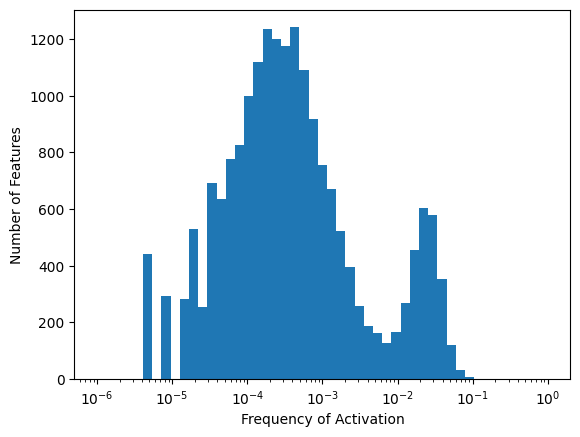

In [9]:
# plot res_freq
import matplotlib.pyplot as plt
import numpy as np
# do log bins
# plt.hist(res_freq, bins=np.logspace(np.log10(1e-5),np.log10(1e-0), 50))
plt.hist(skip_freq, bins=np.logspace(np.log10(1e-6),np.log10(1e-0), 50))
plt.xlabel("Frequency of Activation")
plt.ylabel("Number of Features")
plt.xscale('log')
plt.show()

In [57]:
# TODO change display corre threshold
# TODO: check if triu-> tril fixes things
# alt, just allow duplicates (by erasing diagonal?)
def get_connection_weights(jacc_sim, global_id_x, global_id_y, display_correlation_threshold=0.4, max_connections=10):
    # Remove all connections that have more than max_conn (they clog up display)
    above_threshold = jacc_sim > display_correlation_threshold
    # (above_threshold.sum(0) > max_num).nonzero(), above_threshold.sum(1) > max_num
    too_high_rows = (above_threshold.sum(1) > max_connections).nonzero()[:, 0]
    too_high_cols = (above_threshold.sum(0) > max_connections).nonzero()[:, 0]
    print(f" Total zeroed out: {len(too_high_rows) + len(too_high_cols)}")
    # Set those to zero 
    jacc_sim[too_high_rows] = 0
    jacc_sim[:, too_high_cols] = 0
    row, col = (jacc_sim > display_correlation_threshold).nonzero().T
    weight = jacc_sim[row, col]
    row = global_id_x[row]
    col = global_id_y[col]
    # if(len(row) > max_length):
    #     print(f"Too many connections, truncating to {max_length}")
    #     row = row[:max_length]
    #     col = col[:max_length]
    #     weight = weight[:max_length]
    return [[row[i].item(), col[i].item(), weight[i].item()] for i in range(len(row))]

res_connections = get_connection_weights(jacc_sim_res_dim0, res_only_global_id, res_only_global_id)
skip_connections = get_connection_weights(jacc_sim_skip_dim0, skip_only_global_id, skip_only_global_id)
cross_connections = get_connection_weights(jacc_sim_res_to_skip, cross_connection_res_global_id, cross_connection_skip_global_id, display_correlation_threshold= 0.25)
print(f"Res Connections: {len(res_connections)}")
print(f"Skip Connections: {len(skip_connections)}")
print(f"Cross Connections: {len(cross_connections)}")

 Total zeroed out: 0
 Total zeroed out: 0
 Total zeroed out: 4
Res Connections: 2184
Skip Connections: 1720
Cross Connections: 619


In [58]:
from collections import Counter

# nz_dict_act_res is size (tokens, features)

# For each feature, get the top-5 tokens by occurance
def get_top_tokens(dictionary_activations, token_list, tokenizer):
    feature_labels = []
    feature_hovertips = []
    for feature in tqdm(dictionary_activations.T):
        nz_feature_ind = feature != 0
        total_nz = nz_feature_ind.sum()
        specific_tokens = token_list[nz_feature_ind].numpy()
        counter = Counter(specific_tokens).most_common(5)
        hovertip_str = ""
        for token_loop_ind, (token, count) in enumerate(counter):
            token_str = tokenizer.decode(token.item())
            percentage = count / total_nz
            token_str = token_str.replace("\n", "\\n").replace(" ", "_")
            # token_str = token_str.replace("Ġ", "_")
            hovertip_str += f"{token_str}: {percentage:.0%}"
            if(token_loop_ind == 0):
                feature_labels.append(token_str)
        feature_hovertips.append(hovertip_str)
    # replace \n w/ \\newline
    # feature_hovertips = [hovertip.replace("\n", "\\n") for hovertip in feature_hovertips]
    # feature_labels = [label.replace("\n", "\\n") for label in feature_labels]
    # replace 'Ġ' w/ _
    # feature_hovertips = [hovertip.replace("Ġ", "_") for hovertip in feature_hovertips]
    # feature_labels = [label.replace("Ġ", "_") for label in feature_labels]


    return feature_labels, feature_hovertips

# Get the top-5 tokens for each feature
# token_list, dictionary_activations_res, dictionary_activations_skip
nz_dict_act_res = dictionary_activations_res[:, global_id_res_group].numpy()
nz_dict_act_skip = dictionary_activations_skip[:, global_id_skip_group].numpy()

res_feature_labels, res_feature_hovertips = get_top_tokens(nz_dict_act_res, token_list, tokenizer)
skip_feature_labels, skip_feature_hovertips = get_top_tokens(nz_dict_act_skip, token_list, tokenizer)

100%|██████████| 1193/1193 [00:19<00:00, 59.95it/s]


In [60]:
import json

# Generate HTML content with correct variable substitution
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Feature Correlation Graph</title>
    <script src="https://d3js.org/d3.v6.min.js"></script>
    <style>
        body, html {{
            margin: 0;
            height: 100%;
            overflow: hidden;
        }}
        .node {{
            stroke: #fff;
            stroke-width: 1.5px;
            opacity: 0.6;
        }}
        .link {{
            stroke: #999;
            stroke-opacity: 0.6;
        }}
        .label {{
            font: 12px sans-serif;
            text-anchor: middle;
        }}
        .tooltip {{
            position: absolute;
            text-align: center;
            width: auto;
            height: auto;
            padding: 5px;
            font: 12px sans-serif;
            background: lightsteelblue;
            border: 0px;
            border-radius: 8px;
            pointer-events: none;
            opacity: 0;
            transition: opacity 0.3s;
        }}
        .zoomable {{
            cursor: grab;
        }}
    </style>
</head>
<body>
    <svg width="100%" height="100%" class="zoomable"></svg>
    <script>
        const resFeatureLabels = {res_feature_labels};
        const skipFeatureLabels = {skip_feature_labels};

        const resFeatureHovertips = {res_feature_hovertips};
        const skipFeatureHovertips = {skip_feature_hovertips};

        const resGlobalID = {res_global_id};
        const skipGlobalID = {skip_global_id};

        const res_connections = {res_connections};
        const skip_connections = {skip_connections};
        const cross_connections = {cross_connections};

        const nodes = [];

        resGlobalID.forEach((global_id, i) => {{
            const full_id_name = `res_${{global_id}}`;
            nodes.push({{ id: full_id_name, group: 'res', color: 'blue', defaultLabel: resFeatureLabels[i], hoverLabel: resFeatureHovertips[i]+ full_id_name}});
        }});

        skipGlobalID.forEach((global_id, i) => {{
            const full_id_name = `skip_${{global_id}}`;
            nodes.push({{ id: full_id_name, group: 'skip', color: 'red', defaultLabel: skipFeatureLabels[i], hoverLabel: skipFeatureHovertips[i]+full_id_name }});
        }});


        const links = [];
        res_connections.forEach(([res_ind_x, res_ind_y, weight]) => {{
            const source = `res_${{res_ind_x}}`;
            const target = `res_${{res_ind_y}}`;
            links.push({{ source: source, target: target, value: weight, color: 'blue' }});
        }});

        skip_connections.forEach(([skip_ind_x, skip_ind_y, weight]) => {{
            const source = `skip_${{skip_ind_x}}`;
            const target = `skip_${{skip_ind_y}}`;
            links.push({{ source: source, target: target, value: weight, color: 'red' }});
        }});

        cross_connections.forEach(([res_ind_x, skip_ind_y, weight]) => {{
            const source = `res_${{res_ind_x}}`;
            const target = `skip_${{skip_ind_y}}`;
            links.push({{ source: source, target: target, value: weight, color: 'purple' }});
        }});

        const svg = d3.select("svg"),
            width = window.innerWidth,
            height = window.innerHeight;

        const tooltip = d3.select("body").append("div")
            .attr("class", "tooltip");

        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(50).strength(1))
            .force("charge", d3.forceManyBody().strength(-30))
            .force("center", d3.forceCenter(width / 2, height / 2))
            .force("x", d3.forceX(width / 2).strength(0.09))
            .force("y", d3.forceY(height / 2).strength(0.09));

        const link = svg.append("g")
            .attr("class", "links")
            .selectAll("line")
            .data(links)
            .enter().append("line")
            .attr("stroke-width", d => Math.sqrt(Math.abs(d.value)))
            .attr("stroke", d => d.color);

        const node = svg.append("g")
            .attr("class", "nodes")
            .selectAll("circle")
            .data(nodes)
            .enter().append("circle")
            .attr("r", 5)
            .attr("fill", d => d.color)
            .attr("opacity", 0.6)
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended))
            .on("mouseover", (event, d) => {{
                tooltip.transition().duration(100).style("opacity", 0.9);
                tooltip.html(d.hoverLabel)
                    .style("left", (event.pageX + 5) + "px")
                    .style("top", (event.pageY - 28) + "px");
            }})
            .on("mouseout", () => {{
                tooltip.transition().duration(350).style("opacity", 0);
            }});

        svg.append("g")
            .attr("class", "labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "label")
            .attr("dy", -15)
            .text(d => d.defaultLabel);

        simulation.on("tick", () => {{
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);

            svg.selectAll(".label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);
        }});

        svg.call(d3.zoom().on("zoom", (event) => {{
            svg.attr("transform", event.transform);
        }}));

        function dragstarted(event, d) {{
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }}

        function dragged(event, d) {{
            d.fx = event.x;
            d.fy = event.y;
        }}

        function dragended(event, d) {{
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }}
    </script>
</body>
</html>
"""

# Generate the HTML content
html_content = html_template.format(
    res_feature_labels=json.dumps(res_feature_labels),
    skip_feature_labels=json.dumps(skip_feature_labels),
    res_feature_hovertips=json.dumps(res_feature_hovertips),
    skip_feature_hovertips=json.dumps(skip_feature_hovertips),
    res_global_id=json.dumps(global_id_res_group.tolist()),
    skip_global_id=json.dumps(global_id_skip_group.tolist()),
    res_connections=json.dumps(res_connections),
    skip_connections=json.dumps(skip_connections),
    cross_connections=json.dumps(cross_connections),
)

# Write the HTML content to a file
with open('tiny_graph.html', 'w') as f:
    f.write(html_content)


In [105]:
cos_sim[61].mean(), cos_sim.shape

(tensor(0.3292, device='cuda:0'), torch.Size([25000, 25000]))

In [110]:
cos_sim.mean(dim=-1).topk(10), cos_sim.mean(dim=-1)[4288]

(torch.return_types.topk(
 values=tensor([0.3292, 0.2422, 0.2302, 0.2213, 0.2169, 0.2168, 0.2141, 0.2138, 0.2094,
         0.2081], device='cuda:0'),
 indices=tensor([   61, 11614,  6768, 10452, 10741, 10453,  7194,  6326, 12940,  7447],
        device='cuda:0')),
 tensor(0.1370, device='cuda:0'))

tensor(0.3292, device='cuda:0') tensor(0.3417, device='cuda:0')


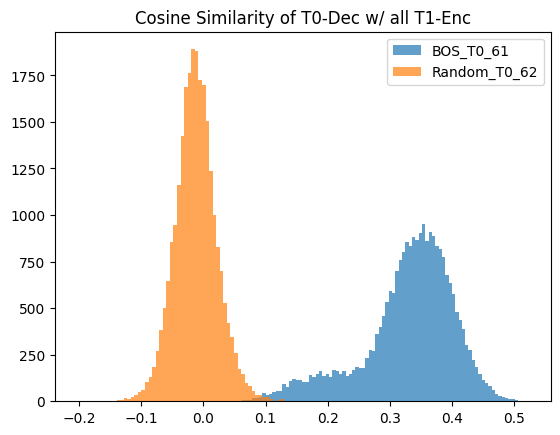

In [99]:
bos_cos_sim = sae_res_decoder[:, 61] @ sae_skip_encoder.T
print(bos_cos_sim.mean(), bos_cos_sim.median())
random_other_point = sae_res_decoder[:, 62] @ sae_skip_encoder.T
from matplotlib import pyplot as plt
plt.hist(bos_cos_sim.cpu().numpy(), bins=100, alpha=0.7, label="BOS_T0_61")
plt.hist(random_other_point.cpu().numpy(), bins=100, alpha=0.7, label="Random_T0_62")
plt.title("Cosine Similarity of T0-Dec w/ all T1-Enc")
plt.legend()
plt.show()

In [16]:
import json
import torch

# Commented out example data, assume these are defined earlier
# jacc_sim_res_dim0 = torch.load('path_to_res_dim0_tensor.pt')  # Replace with your actual tensor path
# jacc_sim_skip_dim0 = torch.load('path_to_skip_dim0_tensor.pt')  # Replace with your actual tensor path
# jacc_sim_res_to_skip = torch.load('path_to_res_to_skip_tensor.pt')  # Replace with your actual tensor path

# # Set a threshold for filtering weak connections
# threshold = 0.8

# def filter_connections(matrix, threshold):
#     indices = torch.nonzero(matrix >= threshold, as_tuple=False)
#     filtered_connections = []
#     for i in range(matrix.size(0)):
#         connections = [[j.item(), matrix[i, j].item()] for j in indices[indices[:, 0] == i][:, 1]]
#         filtered_connections.append(connections)
#     return filtered_connections

# filtered_within_res = filter_connections(jacc_sim_res_dim0, threshold)
# filtered_within_skip = filter_connections(jacc_sim_skip_dim0, threshold)
# filtered_res_to_skip = filter_connections(jacc_sim_res_to_skip, threshold)

# def get_connected_nodes(filtered_connections):
#     connected_nodes = set()
#     for i, connections in enumerate(filtered_connections):
#         if connections:
#             connected_nodes.add(i)
#             for j, _ in connections:
#                 connected_nodes.add(j)
#     return connected_nodes

# connected_res_nodes = get_connected_nodes(filtered_within_res)
# connected_skip_nodes = get_connected_nodes(filtered_within_skip)
# connected_res_to_skip_nodes = set()
# for i, connections in enumerate(filtered_res_to_skip):
#     if connections:
#         connected_res_to_skip_nodes.add(i)
#         for j, _ in connections:
#             connected_skip_nodes.add(j)

# connected_res_nodes = connected_res_nodes.union(connected_res_to_skip_nodes)

# Derive shapes from the tensor sizes
# res_feature_labels = ["Res_Feature_" + str(i) for i in range(jacc_sim_res_dim0.size(0)) if i in connected_res_nodes]
# skip_feature_labels = ["Skip_Feature_" + str(i) for i in range(jacc_sim_skip_dim0.size(0)) if i in connected_skip_nodes]
# res_feature_hovertips = ["Res_Hover_" + str(i) for i in range(jacc_sim_res_dim0.size(0)) if i in connected_res_nodes]
# skip_feature_hovertips = ["Skip_Hover_" + str(i) for i in range(jacc_sim_skip_dim0.size(0)) if i in connected_skip_nodes]

# Generate HTML content with correct variable substitution
html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Feature Correlation Graph</title>
    <script src="https://d3js.org/d3.v6.min.js"></script>
    <style>
        body, html {{
            margin: 0;
            height: 100%;
            overflow: hidden;
        }}
        .node {{
            stroke: #fff;
            stroke-width: 1.5px;
            opacity: 0.6;
        }}
        .link {{
            stroke: #999;
            stroke-opacity: 0.6;
        }}
        .label {{
            font: 12px sans-serif;
            text-anchor: middle;
        }}
        .hover-label {{
            visibility: hidden;
            font: 12px sans-serif;
            text-anchor: middle;
            pointer-events: none;
            background-color: white;
            padding: 2px;
            border-radius: 2px;
        }}
        .zoomable {{
            cursor: grab;
        }}
    </style>
</head>
<body>
    <svg width="100%" height="100%" class="zoomable"></svg>
    <script>
        const resFeatureLabels = {res_feature_labels};
        const skipFeatureLabels = {skip_feature_labels};
        const resFeatureHovertips = {res_feature_hovertips};
        const skipFeatureHovertips = {skip_feature_hovertips};
        const withinResCorrelation = {within_res_correlation};
        const withinSkipCorrelation = {within_skip_correlation};
        const resSkipCorrelation = {res_skip_correlation};

        const nodes = [];
        const nodeIdMap = new Map();

        resFeatureLabels.forEach((label, i) => {{
            const nodeId = `res_${{i}}`;
            nodes.push({{ id: nodeId, group: 'res', color: 'blue', defaultLabel: label, hoverLabel: resFeatureHovertips[i] }});
            nodeIdMap.set(i, nodeId);
        }});

        skipFeatureLabels.forEach((label, i) => {{
            const nodeId = `skip_${{i}}`;
            nodes.push({{ id: nodeId, group: 'skip', color: 'red', defaultLabel: label, hoverLabel: skipFeatureHovertips[i] }});
            nodeIdMap.set(i, nodeId);
        }});

        const links = [];
        withinResCorrelation.forEach((connections, i) => {{
            if (!Array.isArray(connections) || connections.length === 0) {{
                return;
            }}
            connections.forEach(([j, value]) => {{
                const source = nodeIdMap.get(i);
                const target = nodeIdMap.get(j);
                links.push({{ source: source, target: target, value: value, color: 'blue' }});
            }});
        }});

        withinSkipCorrelation.forEach((connections, i) => {{
            if (!Array.isArray(connections) || connections.length === 0) {{
                return;
            }}
            connections.forEach(([j, value]) => {{
                const source = nodeIdMap.get(i);
                const target = nodeIdMap.get(j);
                links.push({{ source: source, target: target, value: value, color: 'red' }});
            }});
        }});

        resSkipCorrelation.forEach((connections, i) => {{
            if (!Array.isArray(connections) || connections.length === 0) {{
                return;
            }}
            connections.forEach(([j, value]) => {{
                const source = nodeIdMap.get(i);
                const target = nodeIdMap.get(j + resFeatureLabels.length);
                links.push({{ source: source, target: target, value: value, color: 'green' }});
            }});
        }});

        const svg = d3.select("svg"),
            width = window.innerWidth,
            height = window.innerHeight;

        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(50).strength(1))
            .force("charge", d3.forceManyBody().strength(-30))
            .force("center", d3.forceCenter(width / 2, height / 2))
            .force("x", d3.forceX(width / 2).strength(0.1))
            .force("y", d3.forceY(height / 2).strength(0.1));

        const link = svg.append("g")
            .attr("class", "links")
            .selectAll("line")
            .data(links)
            .enter().append("line")
            .attr("stroke-width", d => Math.sqrt(Math.abs(d.value)))
            .attr("stroke", d => d.color);

        const node = svg.append("g")
            .attr("class", "nodes")
            .selectAll("circle")
            .data(nodes)
            .enter().append("circle")
            .attr("r", 5)
            .attr("fill", d => d.color)
            .attr("opacity", 0.6)
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended))
            .on("mouseover", function(event, d) {{
                d3.select(this).attr("opacity", 1);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "visible");
            }})
            .on("mouseout", function(event, d) {{
                d3.select(this).attr("opacity", 0.6);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "hidden");
            }});

        svg.append("g")
            .attr("class", "labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "label")
            .attr("dy", -15)
            .text(d => d.defaultLabel);

        svg.append("g")
            .attr("class", "hover-labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "hover-label")
            .attr("id", d => `hover-label-${{d.id}}`)
            .attr("dy", -30)
            .text(d => d.hoverLabel);

        simulation.on("tick", () => {{
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);

            svg.selectAll(".label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);

            svg.selectAll(".hover-label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);
        }});

        svg.call(d3.zoom().on("zoom", (event) => {{
            svg.attr("transform", event.transform);
        }}));

        function dragstarted(event, d) {{
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }}

        function dragged(event, d) {{
            d.fx = event.x;
            d.fy = event.y;
        }}

        function dragended(event, d) {{
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }}
    </script>
</body>
</html>
"""

# Generate the HTML content
html_content = html_template.format(
    res_feature_labels=json.dumps(res_feature_labels),
    skip_feature_labels=json.dumps(skip_feature_labels),
    res_feature_hovertips=json.dumps(res_feature_hovertips),
    skip_feature_hovertips=json.dumps(skip_feature_hovertips),
    within_res_correlation=json.dumps(filtered_within_res),
    within_skip_correlation=json.dumps(filtered_within_skip),
    res_skip_correlation=json.dumps(filtered_res_to_skip)
)

# Write the HTML content to a file
with open('graph.html', 'w') as f:
    f.write(html_content)


In [102]:
filtered_within_res[0]

[(2539, 0.5762711763381958), (3130, 1.0)]

In [ ]:
import torch

# Your actual data should be assigned to these variables
# res_feature_labels = [...]  # Replace with your actual data
# skip_feature_labels = [...]  # Replace with your actual data
# jacc_sim_res_dim0 = torch.tensor([...])  # Replace with your actual tensor
# jacc_sim_skip_dim0 = torch.tensor([...])  # Replace with your actual tensor
# jacc_sim_res_to_skip = torch.tensor([...])  # Replace with your actual tensor

# Set a threshold for filtering weak connections
threshold = 0.1

def filter_connections(matrix, threshold):
    filtered_connections = []
    for i in tqdm(range(matrix.size(0))):
        connections = []
        for j in range(matrix.size(1)):
            if matrix[i, j] >= threshold:
                connections.append((j, matrix[i, j].item()))
        filtered_connections.append(connections)
    return filtered_connections

# Filter the matrices based on the threshold
filtered_within_res = filter_connections(jacc_sim_res_dim0, threshold)
filtered_within_skip = filter_connections(jacc_sim_skip_dim0, threshold)
filtered_res_to_skip = filter_connections(jacc_sim_res_to_skip, threshold)

html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Feature Correlation Graph</title>
    <script src="https://d3js.org/d3.v6.min.js"></script>
    <style>
        .node {{
            stroke: #fff;
            stroke-width: 1.5px;
            opacity: 0.6;
        }}
        .link {{
            stroke: #999;
            stroke-opacity: 0.6;
        }}
        .label {{
            font: 12px sans-serif;
            text-anchor: middle;
        }}
        .hover-label {{
            visibility: hidden;
            font: 12px sans-serif;
            text-anchor: middle;
            pointer-events: none;
        }}
    </style>
</head>
<body>
    <svg width="1600" height="900"></svg>
    <script>
        // Data for the graph
        const resFeatureLabels = {res_feature_labels};
        const skipFeatureLabels = {skip_feature_labels};
        const withinResCorrelation = {within_res_correlation};
        const withinSkipCorrelation = {within_skip_correlation};
        const resSkipCorrelation = {res_skip_correlation};

        // Create nodes
        const nodes = [];
        for (let i = 0; i < resFeatureLabels.length; i++) {{
            nodes.push({{ id: `res_${{i}}`, group: 'res', color: 'blue', defaultLabel: resFeatureLabels[i], hoverLabel: `Hover info for {{resFeatureLabels[i]}}` }});
        }}
        for (let i = 0; i < skipFeatureLabels.length; i++) {{
            nodes.push({{ id: `skip_${{i}}`, group: 'skip', color: 'red', defaultLabel: skipFeatureLabels[i], hoverLabel: `Hover info for {{skipFeatureLabels[i]}}` }});
        }}

        // Create links (only for non-zero weights)
        const links = [];
        withinResCorrelation.forEach((connections, i) => {{
            connections.forEach(([j, value]) => {{
                links.push({{ source: `res_${{i}}`, target: `res_${{j}}`, value: value, color: 'blue' }});
            }});
        }});
        withinSkipCorrelation.forEach((connections, i) => {{
            connections.forEach(([j, value]) => {{
                links.push({{ source: `skip_${{i}}`, target: `skip_${{j}}`, value: value, color: 'red' }});
            }});
        }});
        resSkipCorrelation.forEach((connections, i) => {{
            connections.forEach(([j, value]) => {{
                links.push({{ source: `res_${{i}}`, target: `skip_${{j}}`, value: value, color: 'green' }});
            }});
        }});

        // Set up SVG and simulation
        const svg = d3.select("svg"),
            width = +svg.attr("width"),
            height = +svg.attr("height");

        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(50).strength(d => Math.exp(-d.value)))
            .force("charge", d3.forceManyBody().strength(-500))
            .force("center", d3.forceCenter(width / 2, height / 2));

        // Add links
        const link = svg.append("g")
            .attr("class", "links")
            .selectAll("line")
            .data(links)
            .enter().append("line")
            .attr("stroke-width", d => Math.sqrt(Math.abs(d.value)))
            .attr("stroke", d => d.color);

        // Add nodes
        const node = svg.append("g")
            .attr("class", "nodes")
            .selectAll("circle")
            .data(nodes)
            .enter().append("circle")
            .attr("r", 5)
            .attr("fill", d => d.color)
            .attr("opacity", 0.6)
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended))
            .on("mouseover", function(event, d) {{
                d3.select(this).attr("opacity", 1);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "visible");
            }})
            .on("mouseout", function(event, d) {{
                d3.select(this).attr("opacity", 0.6);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "hidden");
            }});

        // Add visible labels
        svg.append("g")
            .attr("class", "labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "label")
            .attr("dy", -15)
            .text(d => d.defaultLabel);

        // Add hover labels
        svg.append("g")
            .attr("class", "hover-labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "hover-label")
            .attr("id", d => `hover-label-${{d.id}}`)
            .attr("dy", -30)
            .text(d => d.hoverLabel);

        // Update simulation on each tick
        simulation.on("tick", () => {{
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);

            svg.selectAll(".label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);

            svg.selectAll(".hover-label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);
        }});

        // Drag functions
        function dragstarted(event, d) {{
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }}

        function dragged(event, d) {{
            d.fx = event.x;
            d.fy = event.y;
        }}

        function dragended(event, d) {{
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }}
    </script>
</body>
</html>
"""

# Generate the HTML content
html_content = html_template.format(
    res_feature_labels=res_feature_labels,
    skip_feature_labels=skip_feature_labels,
    within_res_correlation=filtered_within_res,
    within_skip_correlation=filtered_within_skip,
    res_skip_correlation=filtered_res_to_skip
)

# Write the HTML content to a file
with open('graph.html', 'w') as f:
    f.write(html_content)


In [ ]:
filtered_within_res

In [92]:
for threshold in [0.01,0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(f" {(jacc_sim_skip_dim0 > threshold).sum()} connections above {threshold}")
    print(f" {(jacc_sim_res_dim0 > threshold).sum()} connections above {threshold}")
    print(f" {(jacc_sim_res_to_skip > threshold).sum()} connections above {threshold}")
    print("------------------------------------------------------------")

 2020103 connections above 0.01
 1856736 connections above 0.01
 2166155 connections above 0.01
------------------------------------------------------------
 982590 connections above 0.05
 590663 connections above 0.05
 1078060 connections above 0.05
------------------------------------------------------------
 395397 connections above 0.1
 228890 connections above 0.1
 467454 connections above 0.1
------------------------------------------------------------
 107448 connections above 0.2
 55632 connections above 0.2
 116926 connections above 0.2
------------------------------------------------------------
 47336 connections above 0.3
 20386 connections above 0.3
 43322 connections above 0.3
------------------------------------------------------------
 25744 connections above 0.4
 9977 connections above 0.4
 21734 connections above 0.4
------------------------------------------------------------
 15718 connections above 0.5
 6015 connections above 0.5
 13693 connections above 0.5
------

In [9]:
import torch

# Example data
num_features = 5
within_res_correlation = torch.randn(num_features, num_features).tolist()
res_skip_correlation = torch.randn(num_features, num_features).tolist()
within_skip_correlation = torch.randn(num_features, num_features).tolist()
default_labels = [f'Feature_{i}' for i in range(num_features)]
hover_labels = [f'Hover info for Feature_{i}' for i in range(num_features)]

html_template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Feature Correlation Graph</title>
    <script src="https://d3js.org/d3.v6.min.js"></script>
    <style>
        .node {{
            stroke: #fff;
            stroke-width: 1.5px;
            opacity: 0.6;
        }}
        .link {{
            stroke: #999;
            stroke-opacity: 0.6;
        }}
        .label {{
            font: 12px sans-serif;
            text-anchor: middle;
        }}
        .hover-label {{
            visibility: hidden;
            font: 12px sans-serif;
            text-anchor: middle;
            pointer-events: none;
        }}
    </style>
</head>
<body>
    <svg width="960" height="600"></svg>
    <script>
        // Data for the graph
        const numFeatures = {num_features};
        const withinResCorrelation = {within_res_correlation};
        const resSkipCorrelation = {res_skip_correlation};
        const withinSkipCorrelation = {within_skip_correlation};
        const defaultLabels = {default_labels};
        const hoverLabels = {hover_labels};

        // Create nodes
        const nodes = [];
        for (let i = 0; i < numFeatures; i++) {{
            nodes.push({{ id: `res_${{i}}`, group: 'res', color: 'blue', defaultLabel: defaultLabels[i], hoverLabel: hoverLabels[i] }});
            nodes.push({{ id: `skip_${{i}}`, group: 'skip', color: 'red', defaultLabel: defaultLabels[i], hoverLabel: hoverLabels[i] }});
        }}

        // Create links
        const links = [];
        for (let i = 0; i < numFeatures; i++) {{
            for (let j = 0; j < numFeatures; j++) {{
                if (i !== j) {{
                    links.push({{ source: `res_${{i}}`, target: `res_${{j}}`, value: withinResCorrelation[i][j], color: 'blue' }});
                    links.push({{ source: `skip_${{i}}`, target: `skip_${{j}}`, value: withinSkipCorrelation[i][j], color: 'red' }});
                }}
                links.push({{ source: `res_${{i}}`, target: `skip_${{j}}`, value: resSkipCorrelation[i][j], color: 'green' }});
            }}
        }}

        // Set up SVG and simulation
        const svg = d3.select("svg"),
            width = +svg.attr("width"),
            height = +svg.attr("height");

        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(50).strength(1))
            .force("charge", d3.forceManyBody().strength(-400))
            .force("center", d3.forceCenter(width / 2, height / 2));

        // Add links
        const link = svg.append("g")
            .attr("class", "links")
            .selectAll("line")
            .data(links)
            .enter().append("line")
            .attr("stroke-width", d => Math.sqrt(d.value))
            .attr("stroke", d => d.color);

        // Add nodes
        const node = svg.append("g")
            .attr("class", "nodes")
            .selectAll("circle")
            .data(nodes)
            .enter().append("circle")
            .attr("r", 10)
            .attr("fill", d => d.color)
            .attr("opacity", 0.6)
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended))
            .on("mouseover", function(event, d) {{
                d3.select(this).attr("opacity", 1);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "visible");
            }})
            .on("mouseout", function(event, d) {{
                d3.select(this).attr("opacity", 0.6);
                svg.select(`#hover-label-${{d.id}}`).style("visibility", "hidden");
            }});

        // Add visible labels
        svg.append("g")
            .attr("class", "labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "label")
            .attr("dy", -15)
            .text(d => d.defaultLabel);

        // Add hover labels
        svg.append("g")
            .attr("class", "hover-labels")
            .selectAll("text")
            .data(nodes)
            .enter().append("text")
            .attr("class", "hover-label")
            .attr("id", d => `hover-label-${{d.id}}`)
            .attr("dy", -30)
            .text(d => d.hoverLabel);

        // Update simulation on each tick
        simulation.on("tick", () => {{
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node
                .attr("cx", d => d.x)
                .attr("cy", d => d.y);

            svg.selectAll(".label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);

            svg.selectAll(".hover-label")
                .attr("x", d => d.x)
                .attr("y", d => d.y);
        }});

        // Drag functions
        function dragstarted(event, d) {{
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }}

        function dragged(event, d) {{
            d.fx = event.x;
            d.fy = event.y;
        }}

        function dragended(event, d) {{
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }}
    </script>
</body>
</html>
"""

# Generate the HTML content
html_content = html_template.format(
    num_features=num_features,
    within_res_correlation=within_res_correlation,
    res_skip_correlation=res_skip_correlation,
    within_skip_correlation=within_skip_correlation,
    default_labels=default_labels,
    hover_labels=hover_labels
)

# Write the HTML content to a file
with open('graph.html', 'w') as f:
    f.write(html_content)

In [5]:
# Okay, now let's just naively multiply the decoder weight by the encoder weight
res_dec = sae_res.decoder.weight.data
skip_enc = skip_sae.encoder.weight.data
combined = skip_enc @ res_dec
# res_dec = sae_res.encoder.weight.data
# skip_dec = skip_sae.decoder.weight.data
# combined = res_dec@ skip_dec
combined.shape

torch.Size([8192, 8192])

In [6]:
# w_writing -= W_writing.mean(dim=1, keepdim=True)

In [16]:
# I'd like to fold in layer norm
ln_mlp = model.gpt_neox.layers[layer].post_attention_layernorm
# 1. center the weights that write into res
centered_decoder = res_dec - res_dec.mean(dim=1, keepdim=True)
# 2. Add in layer norm weight to the read in weight
ln_w = ln_mlp.weight.data
ln_b = ln_mlp.bias.data

# Get weights and biases of the next linear layer
W = skip_sae.encoder.weight.data.T  # The next linear layer weights
# B = skip_sae.mag_bias.data  # The next linear layer biases
B = skip_sae.gate_bias.data  # The next linear layer biases

# Calculate W_eff and B_eff
W_eff = torch.diag(ln_w) @ W
B_eff = B + ln_b @ W

# Centering the reading weights
W_eff -= W_eff.mean(dim=0, keepdim=True)

In [12]:
centered_decoder.shape, W_eff.shape

(torch.Size([512, 8192]), torch.Size([512, 8192]))

In [17]:
ln_mlp = model.gpt_neox.layers[2].post_attention_layernorm

for d_point_ind in range(1,20):
    print(f"Data Point {d_point_ind}")
    f1 = dictionary_activations_res[d_point_ind].to(device)
    f2 = dictionary_activations_skip[d_point_ind].to(device)
    f2_hat = torch.clamp(combined @ f1, min=0)
    test_f2 = torch.clamp(skip_enc @ ln_mlp(res_dec@f1), min=0)
    new_f2 = torch.clamp(skip_sae.encode(ln_mlp(sae_res.decode(f1))), min=0)
    fold_in_test = torch.clamp((W_eff.T @ centered_decoder @ f1) + B_eff, min=0) 
    print(torch.allclose(test_f2, f2_hat, atol=1e-5))
    top_ind = f2.topk(5).indices
    # for ind in top_ind:
    #     print(f"{fold_in_test[ind]:.2f}, {test_f2[ind]:.2f}, {f2[ind]:.2f}")
    mse = torch.mean((f2[top_ind] - new_f2[top_ind])**2)
    mse_ln = torch.mean((f2[top_ind] - test_f2[top_ind])**2)
    print(f"fold_in_test: {mse:.2f}, MSE LN: {mse_ln:.2f}")

Data Point 1
False
fold_in_test: 0.53, MSE LN: 0.42
Data Point 2
False
fold_in_test: 0.22, MSE LN: 0.26
Data Point 3
False
fold_in_test: 0.49, MSE LN: 0.51
Data Point 4
False
fold_in_test: 0.78, MSE LN: 0.66
Data Point 5
False
fold_in_test: 0.48, MSE LN: 0.25
Data Point 6
False
fold_in_test: 0.48, MSE LN: 0.54
Data Point 7
False
fold_in_test: 0.60, MSE LN: 0.70
Data Point 8
False
fold_in_test: 0.36, MSE LN: 0.35
Data Point 9
False
fold_in_test: 0.40, MSE LN: 0.34
Data Point 10
False
fold_in_test: 0.93, MSE LN: 0.68
Data Point 11
False
fold_in_test: 0.92, MSE LN: 0.88
Data Point 12
False
fold_in_test: 0.36, MSE LN: 0.32
Data Point 13
False
fold_in_test: 0.93, MSE LN: 0.94
Data Point 14
False
fold_in_test: 0.98, MSE LN: 1.08
Data Point 15
False
fold_in_test: 0.81, MSE LN: 0.87
Data Point 16
False
fold_in_test: 0.34, MSE LN: 0.38
Data Point 17
False
fold_in_test: 0.44, MSE LN: 0.71
Data Point 18
False
fold_in_test: 2.45, MSE LN: 2.28
Data Point 19
False
fold_in_test: 0.47, MSE LN: 0.49


In [131]:
ln_mlp = model.gpt_neox.layers[2].post_attention_layernorm

for d_point_ind in range(20):
    print(f"Data Point {d_point_ind}")
    f1 = dictionary_activations_res[d_point_ind].to(device)
    f2 = dictionary_activations_skip[d_point_ind].to(device)
    f2_hat = combined @ f1
    test_f2 = skip_enc@ ln_mlp(res_dec@f1)
    print(torch.allclose(test_f2, f2_hat, atol=1e-5))
    top_ind = f2.topk(15).indices
    for ind in top_ind:
        print(f"{f2_hat[ind]:.2f}, {test_f2[ind]:.2f}, {f2[ind]:.2f}")

Data Point 0
False
19.93, 4.91, 18.92
7.09, 1.42, 4.08
5.26, 1.19, 2.86
5.00, 1.00, 2.73
4.04, 0.76, 2.53
3.57, 0.69, 2.49
4.49, 0.83, 2.47
4.04, 0.82, 2.46
3.16, 0.65, 2.27
3.43, 0.46, 2.26
3.73, 0.68, 2.26
3.67, 0.78, 2.06
3.16, 0.66, 1.88
3.16, 0.62, 1.87
3.45, 0.52, 1.82
Data Point 1
False
-12.38, -38.03, 2.54
1.54, 4.47, 1.85
-0.70, -3.41, 0.76
0.08, 0.11, 0.26
-0.45, -1.92, 0.24
-0.89, -3.04, 0.21
0.22, 0.24, 0.21
0.85, 1.73, 0.20
0.46, 0.84, 0.20
0.34, 0.13, 0.19
0.18, 0.20, 0.19
0.33, 0.59, 0.17
0.36, 0.59, 0.17
0.35, 0.56, 0.17
0.42, 0.77, 0.17
Data Point 2
False
1.35, 4.18, 1.89
0.13, 0.07, 0.30
0.14, 0.28, 0.27
0.15, -0.02, 0.24
-0.06, -0.07, 0.22
0.14, 0.39, 0.19
0.00, 0.12, 0.19
0.20, 0.31, 0.19
-0.07, -0.31, 0.18
0.42, 0.65, 0.18
0.19, 0.38, 0.18
0.20, 0.26, 0.17
0.16, 0.21, 0.17
0.19, 0.28, 0.16
0.21, 0.45, 0.15
Data Point 3
False
-9.75, -32.72, 3.05
1.00, 3.33, 1.38
-0.02, -1.41, 0.87
0.39, 0.76, 0.58
0.44, 0.75, 0.45
0.26, 0.01, 0.41
0.28, 0.41, 0.32
-0.48, -1.96, 0.27

In [124]:
f2.topk(100)

torch.return_types.topk(
values=tensor([18.9184,  4.0784,  2.8593,  2.7319,  2.5296,  2.4910,  2.4732,  2.4591,
         2.2727,  2.2623,  2.2605,  2.0583,  1.8783,  1.8740,  1.8242,  1.8031,
         1.7778,  1.7658,  1.7558,  1.7549,  1.7464,  1.7331,  1.7292,  1.7254,
         1.6944,  1.6513,  1.6329,  1.6224,  1.6099,  1.6048,  1.5902,  1.5876,
         1.5840,  1.5729,  1.5443,  1.5320,  1.5310,  1.5199,  1.5186,  1.5115,
         1.4694,  1.4676,  1.4634,  1.4531,  1.4170,  1.3952,  1.3948,  1.3786,
         1.3783,  1.3693,  1.3407,  1.3399,  1.3214,  1.2816,  1.2780,  1.2769,
         1.2681,  1.2581,  1.2279,  1.2220,  1.2199,  1.2103,  1.1947,  1.1850,
         1.1832,  1.1656,  1.1646,  1.1210,  1.1034,  1.1017,  1.0879,  1.0501,
         1.0356,  1.0296,  0.9993,  0.9948,  0.9869,  0.9855,  0.9817,  0.9657,
         0.9584,  0.9549,  0.9480,  0.9450,  0.9389,  0.9286,  0.9277,  0.9241,
         0.9195,  0.9180,  0.9137,  0.9105,  0.9043,  0.8979,  0.8928,  0.8752,
        

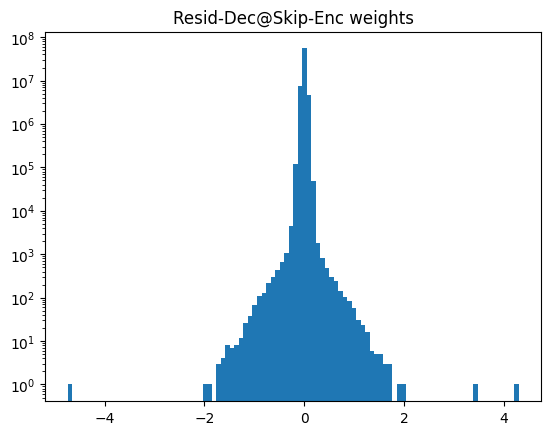

In [97]:
# plot the dist of the combined weights
import matplotlib.pyplot as plt
plt.hist(combined.flatten().cpu().numpy(), bins=100)
# y ax log
plt.title("Resid-Dec@Skip-Enc weights")
# plt.xscale('log')
plt.yscale('log')
plt.show()

In [78]:
combined.max(0).values.topk(10), combined.min(0).values.topk(10, largest=False)

(torch.return_types.topk(
 values=tensor([4.2925, 1.7148, 1.2443, 0.6057, 0.4973, 0.4901, 0.4660, 0.4499, 0.3807,
         0.3700], device='cuda:0'),
 indices=tensor([1477, 5432, 2995, 7856, 7523, 5225, 1493, 5216, 2743, 5933],
        device='cuda:0')),
 torch.return_types.topk(
 values=tensor([-4.7403, -1.7134, -0.6850, -0.5077, -0.4975, -0.4813, -0.4678, -0.3732,
         -0.3674, -0.3619], device='cuda:0'),
 indices=tensor([1477, 5432, 5225, 2995, 6262, 2743, 7523, 8154, 2448, 3895],
        device='cuda:0')))

In [82]:
dictionary_activations_res[:1000].max(0).values.topk(10), dictionary_activations_skip[:1000].max(0).values.topk(10)

(torch.return_types.topk(
 values=tensor([125.2061, 105.0183,  25.0771,   8.0769,   8.0200,   7.4735,   7.1577,
           7.1127,   6.5055,   6.4784]),
 indices=tensor([5224, 6097, 7759, 6353, 2645, 7478, 3580, 1000, 7052,  261])),
 torch.return_types.topk(
 values=tensor([55.4205, 27.9668,  7.3213,  7.2092,  5.2458,  4.8454,  4.8416,  4.3618,
          4.1407,  3.7042]),
 indices=tensor([1477, 7383, 1445, 5432, 1837, 3313, 3054,  174, 1283, 3736])))

In [ ]:
# Create two random res_dec-shaped matrix, and combine them like above
import torch.nn.functional as F
res_dec_rand = F.normalize(torch.randn_like(res_dec), dim=-1)

In [58]:
x_hat = feature_acts
x_hat_prime = skip_feature_x_hat
# Step 1: Compute the mean of x_hat_prime along the batch dimension
x_hat_prime_mean = torch.mean(x_hat_prime, dim=0)

# Step 2: Calculate SS_tot (total sum of squares) for each feature
ss_tot = torch.sum((x_hat_prime - x_hat_prime_mean) ** 2, dim=-1)

# Step 3: Calculate SS_res (residual sum of squares) for each feature
ss_res = torch.sum((x_hat_prime - x_hat) ** 2, dim=-1)
r2 = 1 - (ss_res / ss_tot)
# set nans to 0
# r2[torch.isnan(r2)] = 0
r2

tensor([0.9936, 0.9938, 0.9769,  ..., 0.7565, 0.6615, 0.7212], device='cuda:0')

In [48]:
ss_tot[:3], ss_res[:3], r2[:3]

(tensor([1.2240, 0.0000, 0.4828], device='cuda:0'),
 tensor([1.1337, 0.0000, 0.4043], device='cuda:0'),
 tensor([0.0737,    nan, 0.1626], device='cuda:0'))

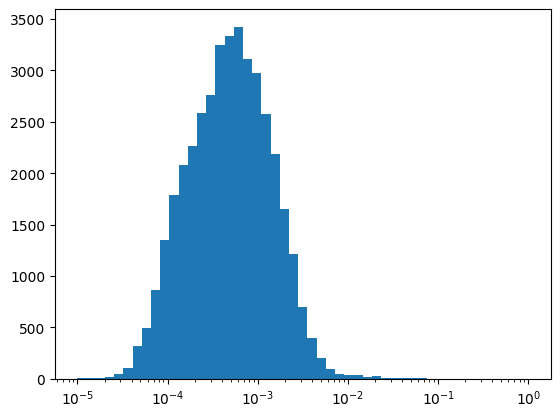

In [37]:
# plot feature_mse with log x bins
import matplotlib.pyplot as plt
import numpy as np

plt.hist(feature_mse.numpy(), bins=np.logspace(-5, 0, 50))
plt.gca().set_xscale("log")
plt.show()

In [16]:
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXSdpaAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
        